In [6]:
import numpy as np
import pandas as pd
import joblib
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import RDConfig, Draw
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import gzip
import os
import sys
import glob
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64
from pathlib import Path 

In [2]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [3]:
sc = SCScorer()
sc.restore(os.path.join('/home/zumrovad/DP/scscore','models', 'full_reaxys_model_1024bool','model.ckpt-10654.as_numpy.json.gz'))
sy = SybaClassifier()
sy.fitDefaultScore()

Restored variables from /home/zumrovad/DP/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


# AiZynthFinder outputs - Scaffolds

In [7]:
path = 'data/balanced_data'
files = Path(path).glob('*.csv') 

In [8]:
all_files = glob.glob(os.path.join(path , "*.csv"))
frames = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    frames.append(df)
df = pd.concat(frames, axis=0, ignore_index=True)

In [11]:
df = df.drop_duplicates(subset = 'target')

In [12]:
len(df)

20000

In [19]:
df = df[df.number_of_steps <= 10]
df = df[df.number_of_steps > 0]

In [21]:
len(df)

15918

In [22]:
df.number_of_steps.value_counts()

3     1916
10    1905
1     1702
9     1634
2     1598
5     1516
4     1435
8     1425
7     1414
6     1373
Name: number_of_steps, dtype: int64

<AxesSubplot:>

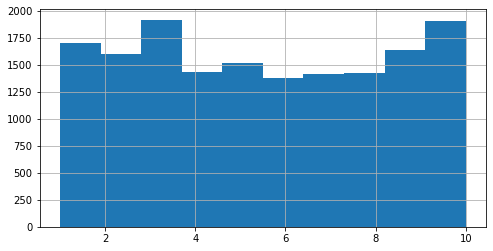

In [24]:
plt.figure(figsize=(8,4))
df.number_of_steps.hist() 

In [25]:
df['steps_bins'] = pd.cut(df['number_of_steps'], [0,1,3,6,10], labels=False) #, labels=False
df.steps_bins.value_counts()

3    6378
2    4324
1    3514
0    1702
Name: steps_bins, dtype: int64

In [27]:
scsc = [sc.get_score_from_smi(smile)[1] for smile in df.target]
syba = [sy.predict(smile) for smile in df.target]
sasc = [sa.calculateScore(Chem.MolFromSmiles(smile)) for smile in df.target]
df = df.assign(scscore=scsc, syba=syba, sascore=sasc)

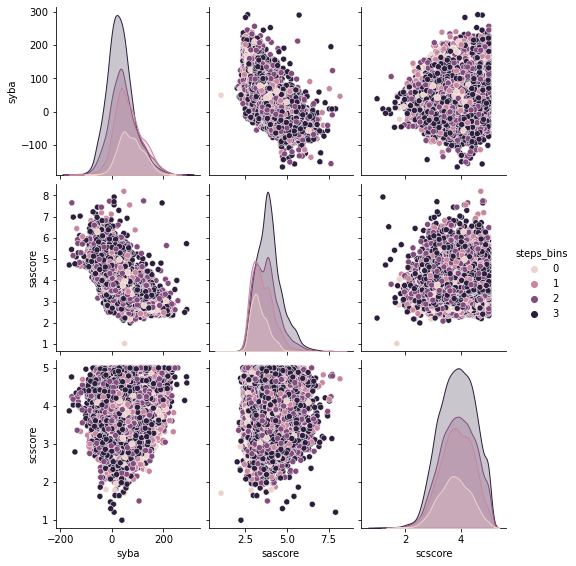

In [30]:
g = sns.pairplot(df[['steps_bins', 'syba', 'sascore', 'scscore']], hue='steps_bins')
g.fig.set_size_inches(8,8)

# Scaffolds

In [31]:
all_mols = [Chem.MolFromSmiles(smile) for smile in df.target]
df['mol'] = all_mols
df["scaf1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf2"] = df['scaf1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaf3"] = df['scaf2'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaf3_smiles"] = df['scaf3'].apply(Chem.MolToSmiles)

### Group number_of_steps = 1

In [32]:
df_1 = df[df.number_of_steps == 1]
scaf_count_1 = df_1['scaf3_smiles'].value_counts()
scaf_count_alldata_1 = pd.DataFrame(scaf_count_1)
scaf_count_alldata_1['scaffold'] = scaf_count_alldata_1.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [34]:
print("Count number_of_steps = 1: ", len(df_1))
print("Count scaffolds: ", len(scaf_count_alldata_1))

Count number_of_steps = 1:  1702
Count scaffolds:  783


In [35]:
scaf_count_alldata_1["prob"] = scaf_count_alldata_1["scaf3_smiles"].apply(lambda x: float(x)/len(df_1))
scaf_count_alldata_1.head(10)

,scaf3_smiles,scaffold,prob
C1CCCCC1,95,<rdkit.Chem.rdchem.Mol object at 0x7f51c004ad00>,0.055817
C1CCCC1,70,<rdkit.Chem.rdchem.Mol object at 0x7f51c004adc0>,0.041128
C1CCC(CCC2CCCC2)CC1,41,<rdkit.Chem.rdchem.Mol object at 0x7f51c4b2ff40>,0.024089
C1CCC(CCCC2CCCC2)CC1,39,<rdkit.Chem.rdchem.Mol object at 0x7f51c4ba4be0>,0.022914
C1CCC(CCCCC2CCCC2)CC1,38,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af280>,0.022327
C1CCC(CC2CCCC2)CC1,33,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af1c0>,0.019389
C1CCC(CCCC2CCCCC2)CC1,26,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af100>,0.015276
C1CCC(CCCCC2CCCCC2)CC1,25,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af160>,0.014689
C1CCC(C2CCCC2)CC1,25,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af2e0>,0.014689
C1CCC(CCC2CCCCC2)CC1,21,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af340>,0.012338


/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


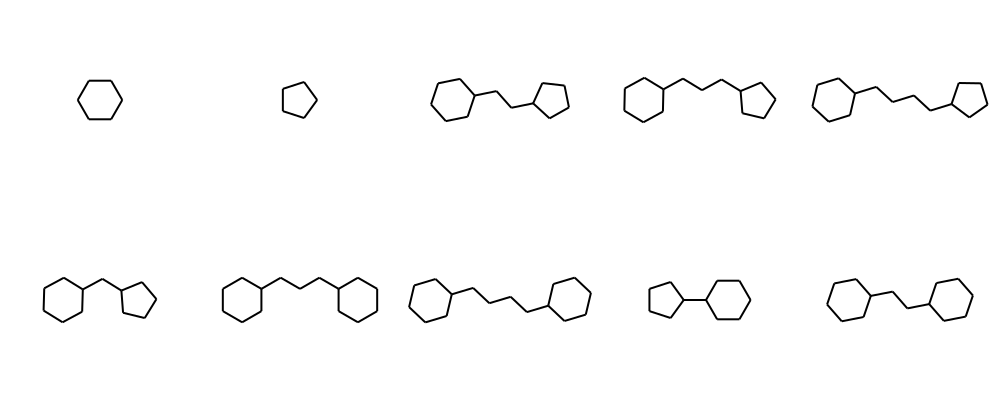

In [36]:
Draw.MolsToGridImage(scaf_count_alldata_1['scaffold'], molsPerRow=5, maxMols=10)

/var/tmp/pbs.44690.lich-compute.vscht.cz/ipykernel_23930/902080607.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = df_1[df.scaf3_smiles == '']


,target,mol,scaf3
890,CCC[C@@H](C)N(C)C[C@H](C)C(N)=S,,
1088,CC[C@@H](C[C@@H](C)CO)NC(=O)C(C)(C)S(C)(=O)=O,,
1947,COCCCC(=O)N[C@@H](C)[C@H](C)NC(=O)CNC(=O)OC,,
3111,CC[C@H](C)OCC(=O)N[C@@H](C)[C@@H](O)C(F)(F)F,,
3269,CCCC[C@@H](CNC(=O)CC(N)=O)NC(=O)C(C)(F)F,,
3306,COC(=O)[C@@H](NC(=O)NC[C@@](C)(O)CC(=O)O)C(C)C,,
3333,CC[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)NCC#N,,
3470,CC(=O)NC[C@H](N[C@@H](C)C(=O)NC(=O)NCC(C)C)C(C)C,,
3814,CC[C@H](C)N(CC)C[C@H](C)C(N)=S,,
4882,CC[C@H](OC)C(=O)N[C@@H](C)CCNC(=O)CNC(C)=O,,

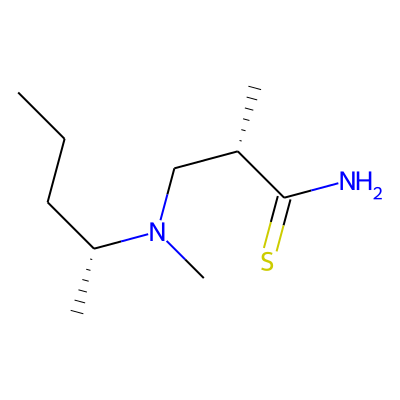
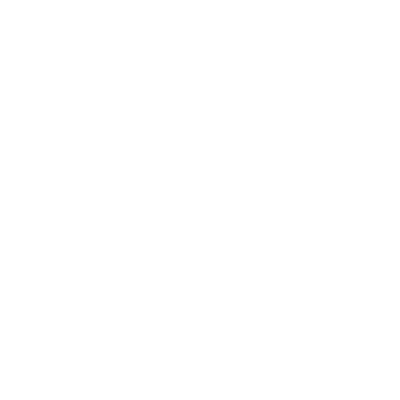
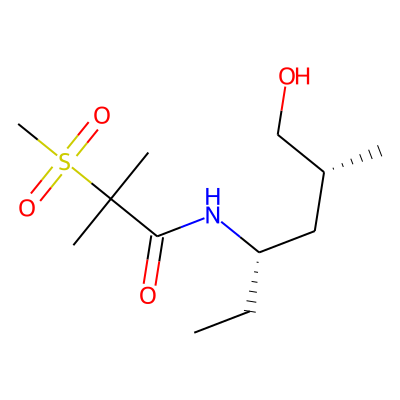
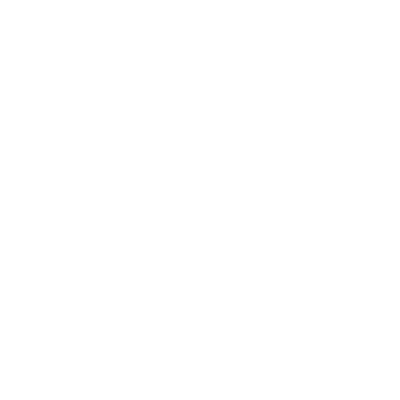
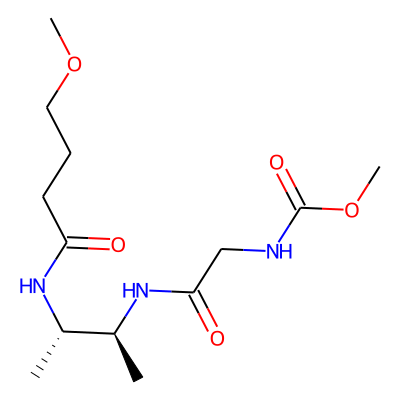
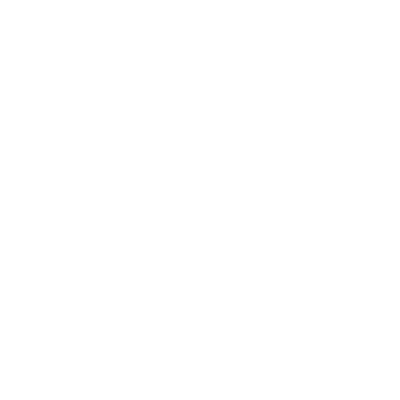
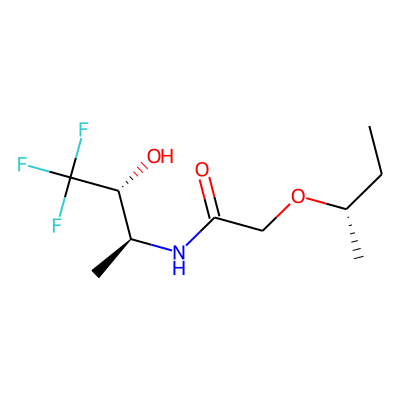
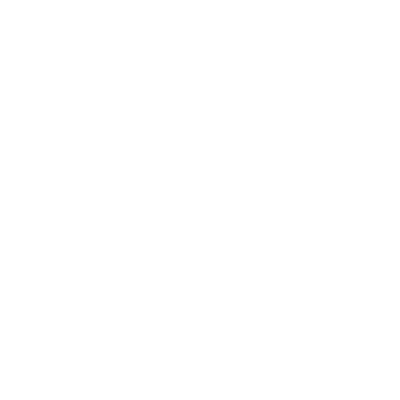
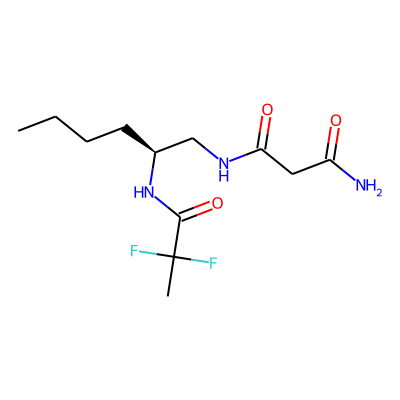
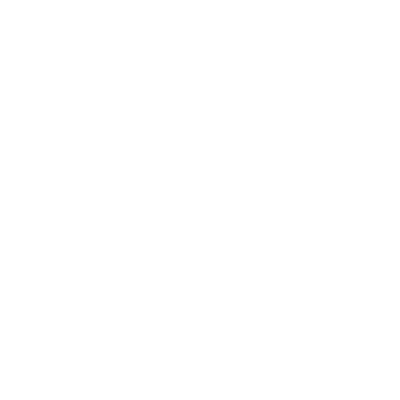
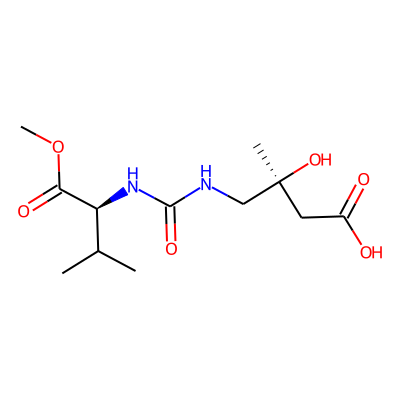
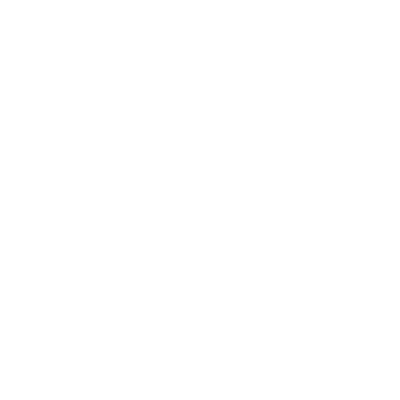
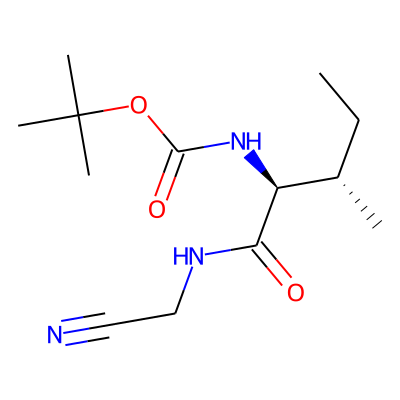
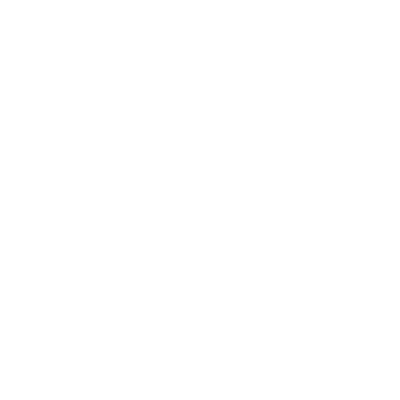
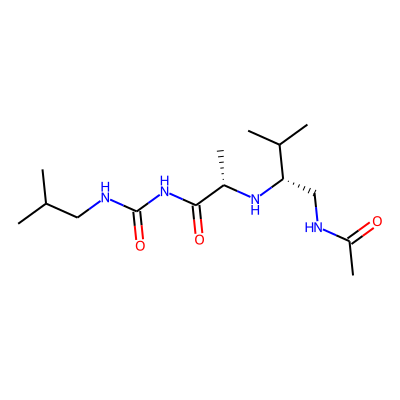
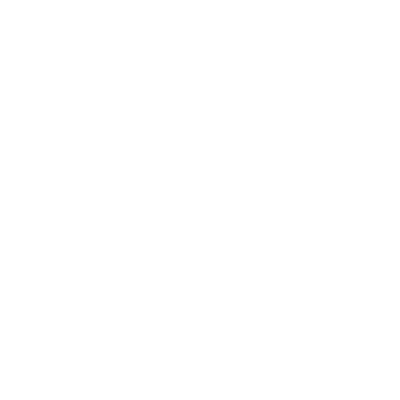
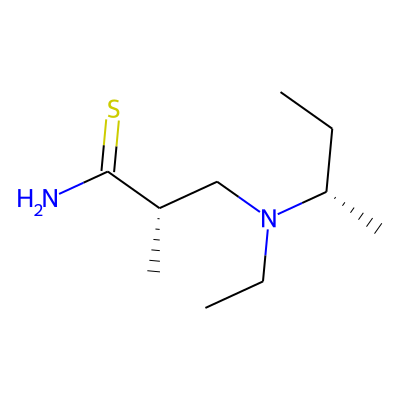
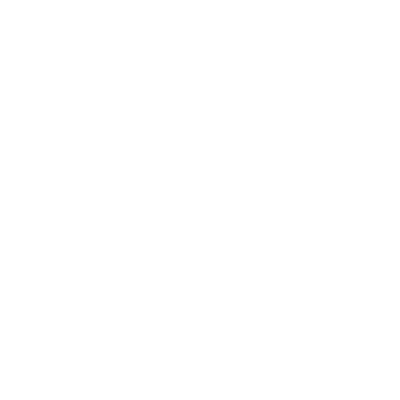
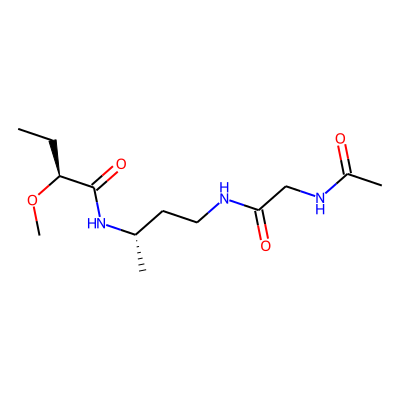
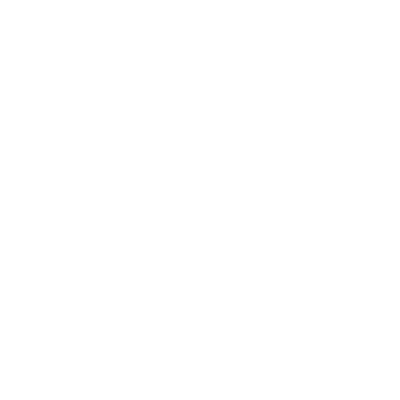
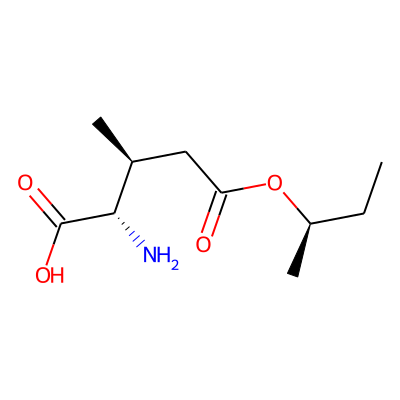
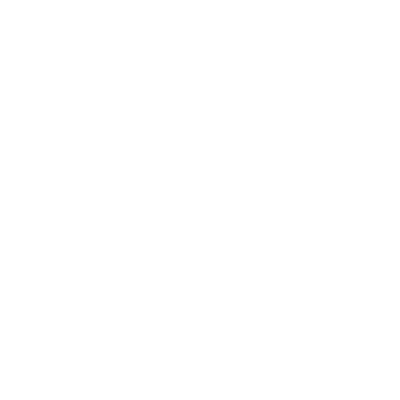
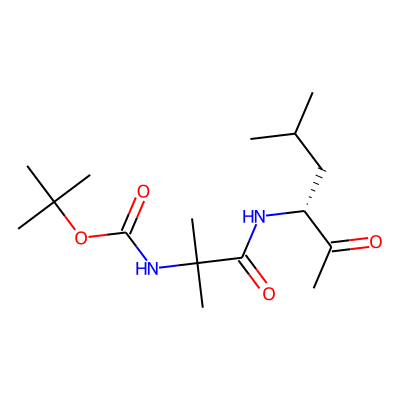
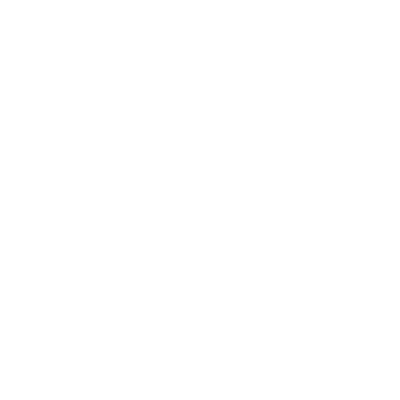
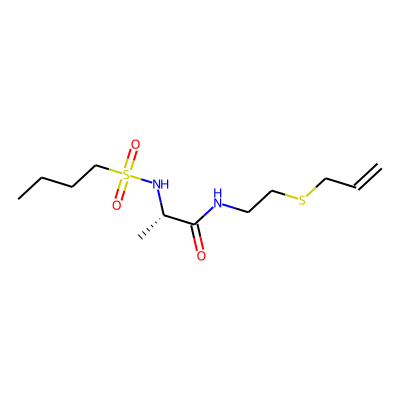
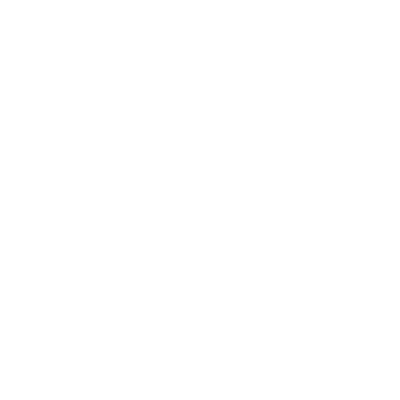
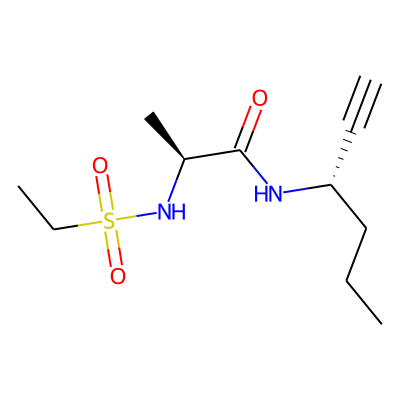
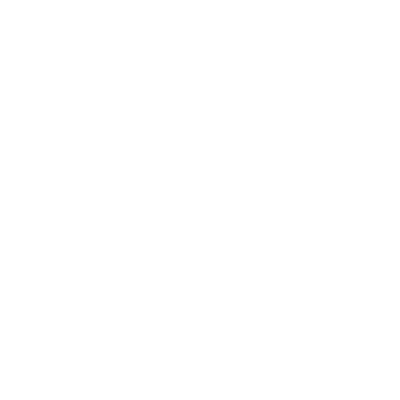
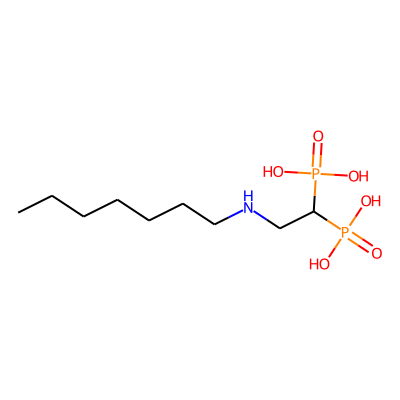
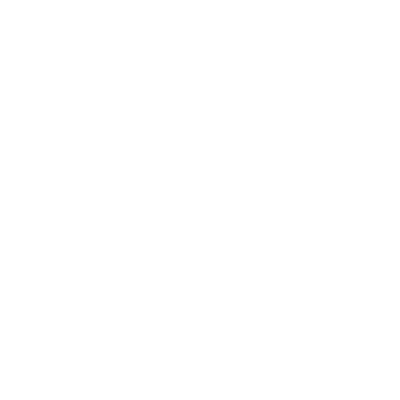
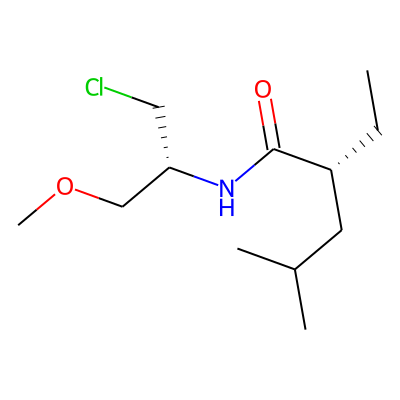
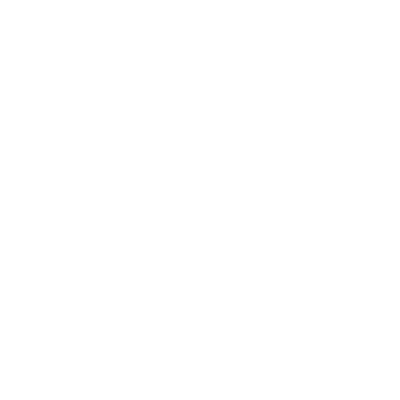
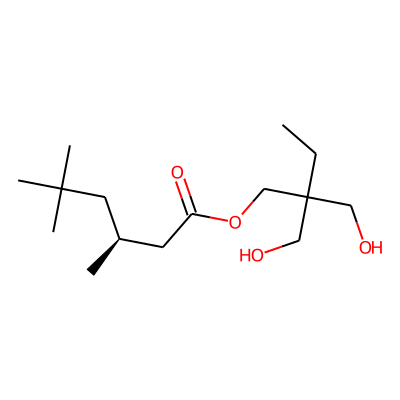
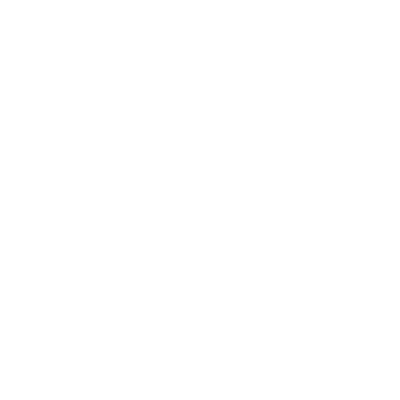

In [37]:
#alldata_1['scaf3_smiles'].iloc[3] == ''
a = df_1[df.scaf3_smiles == '']
HTML(a[['target','mol','scaf3']].to_html(formatters={'mol': mol_display,'scaf3': mol_display}, escape=False))

### Group number_of_steps = 2 and 3

In [38]:
df_2 = df[df.number_of_steps <= 3]
df_2 = df_2[df_2.number_of_steps >= 2]
scaf_count_all_2 = df_2['scaf3_smiles'].value_counts()
scaf_count_alldata_2 = pd.DataFrame(scaf_count_all_2)
scaf_count_alldata_2['scaffold'] = scaf_count_alldata_2.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [39]:
print("Count number_of_steps = 2 and 3: ", len(df_2))
print("Count scaffolds: ", len(scaf_count_alldata_2))

Count number_of_steps = 2 and 3:  3514
Count scaffolds:  1644


In [40]:
scaf_count_alldata_2["prob"] = scaf_count_alldata_2["scaf3_smiles"].apply(lambda x: float(x)/len(df_2))
scaf_count_alldata_2.head(5)

,scaf3_smiles,scaffold,prob
C1CCCCC1,176,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdc0a0>,0.050085
C1CCCC1,105,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdc880>,0.029880
C1CCC(CCC2CCCC2)CC1,70,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdc040>,0.019920
C1CCC(CC2CCCC2)CC1,64,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdc7c0>,0.018213
C1CCC(CC2CCCCC2)CC1,58,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdc3a0>,0.016505


/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


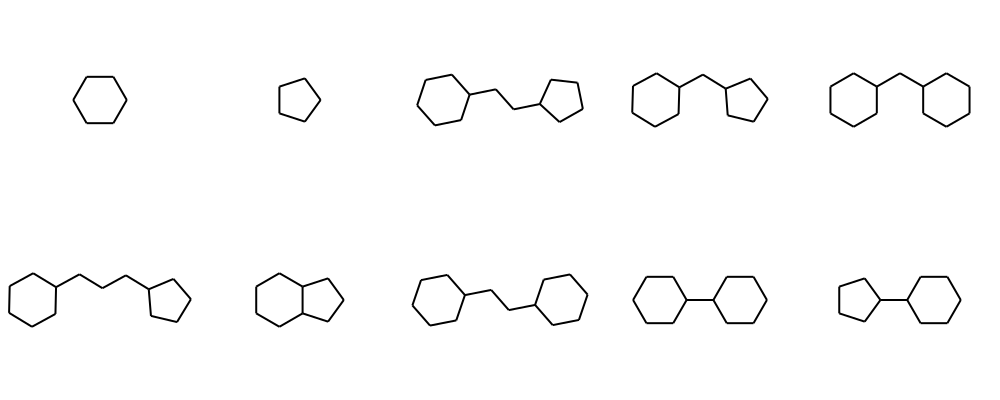

In [41]:
Draw.MolsToGridImage(scaf_count_alldata_2['scaffold'], molsPerRow=5, maxMols=10)

### Group number_of_steps = 4,5,6

In [42]:
df_6 = df[df.number_of_steps <= 6]
df_6 = df_6[df_6.number_of_steps > 3]
scaf_count_all6 = df_6['scaf3_smiles'].value_counts()
scaf_count_alldata_6 = pd.DataFrame(scaf_count_all6)
scaf_count_alldata_6['scaffold'] = scaf_count_alldata_6.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [44]:
df_6.number_of_steps.value_counts()

5    1516
4    1435
6    1373
Name: number_of_steps, dtype: int64

In [45]:
print("Count number_of_steps = 6: ", len(df_6))
print("Count scaffolds: ", len(scaf_count_alldata_6))

Count number_of_steps = 6:  4324
Count scaffolds:  2296


In [46]:
scaf_count_alldata_6["prob"] = scaf_count_alldata_6["scaf3_smiles"].apply(lambda x: float(x)/len(df_6))
scaf_count_alldata_6.head(5)

,scaf3_smiles,scaffold,prob
C1CCCCC1,206,<rdkit.Chem.rdchem.Mol object at 0x7f51baffd880>,0.047641
C1CCCC1,107,<rdkit.Chem.rdchem.Mol object at 0x7f51baffddc0>,0.024746
C1CCC(C2CCCC2)CC1,71,<rdkit.Chem.rdchem.Mol object at 0x7f51baffd400>,0.016420
C1CCC(CC2CCCC2)CC1,64,<rdkit.Chem.rdchem.Mol object at 0x7f51baffd460>,0.014801
C1CCC(CC2CCCCC2)CC1,61,<rdkit.Chem.rdchem.Mol object at 0x7f51baffd940>,0.014107


/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


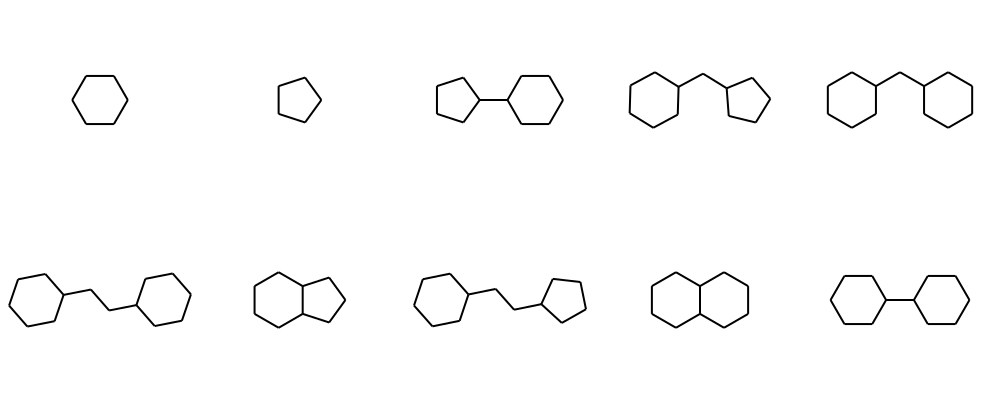

In [47]:
Draw.MolsToGridImage(scaf_count_alldata_6['scaffold'], molsPerRow=5, maxMols=10)

### Group number_of_steps = 7,8,9,10

In [48]:
df_10 = df[df.number_of_steps > 6]
scaf_count_df10 = df_10['scaf3_smiles'].value_counts()
scaf_count_alldata_10 = pd.DataFrame(scaf_count_df10)
scaf_count_alldata_10['scaffold'] = scaf_count_alldata_10.index.to_series().apply(lambda x: Chem.MolFromSmiles(x))

In [49]:
df_10.number_of_steps.value_counts()

10    1905
9     1634
8     1425
7     1414
Name: number_of_steps, dtype: int64

In [50]:
print("Count number_of_steps = 10: ", len(df_10))
print("Count scaffolds: ", len(scaf_count_alldata_10))

Count number_of_steps = 10:  6378
Count scaffolds:  3164


In [51]:
scaf_count_alldata_10["prob"] = scaf_count_alldata_10["scaf3_smiles"].apply(lambda x: float(x)/len(df_10))
scaf_count_alldata_10.head(5)

,scaf3_smiles,scaffold,prob
C1CCCCC1,242,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a1c0>,0.037943
C1CCCC1,135,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a520>,0.021167
C1CCC(C2CCCC2)CC1,106,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a160>,0.016620
C1CCC(CC2CCCCC2)CC1,92,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a280>,0.014425
C1CCC2CCCCC2C1,87,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a460>,0.013641


/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


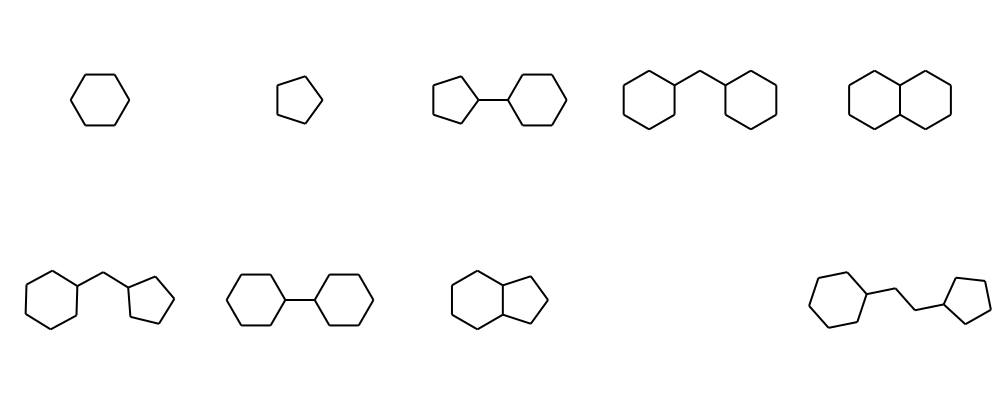

In [52]:
Draw.MolsToGridImage(scaf_count_alldata_10['scaffold'], molsPerRow=5, maxMols=10)

# Unique scaffolds

In [53]:
smil0 = scaf_count_alldata_1.reset_index()
smil0['group'] = 0
smil1 = scaf_count_alldata_2.reset_index()
smil1['group'] = 1
smil2 = scaf_count_alldata_6.reset_index()
smil2['group'] = 2
smil3 = scaf_count_alldata_10.reset_index()
smil3['group'] = 3

In [54]:
len(smil0) + len(smil1) + len(smil2) + len(smil3)

7887

In [55]:
smil = pd.concat([smil0,smil1]) #['scaf3_smiles','scaffold','group']
smil = pd.concat([smil,smil2])
smil = pd.concat([smil,smil3])
smil = smil.rename(columns={"scaf3_smiles": "count"})

In [56]:
smil = smil.drop_duplicates(subset=['index'], keep=False)
smil = smil.sort_values(by=['count'], ascending=False)

In [57]:
smil_uniq_0 = smil[smil.group == 0]
smil_uniq_1 = smil[smil.group == 1]
smil_uniq_2 = smil[smil.group == 2]
smil_uniq_3 = smil[smil.group == 3]

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


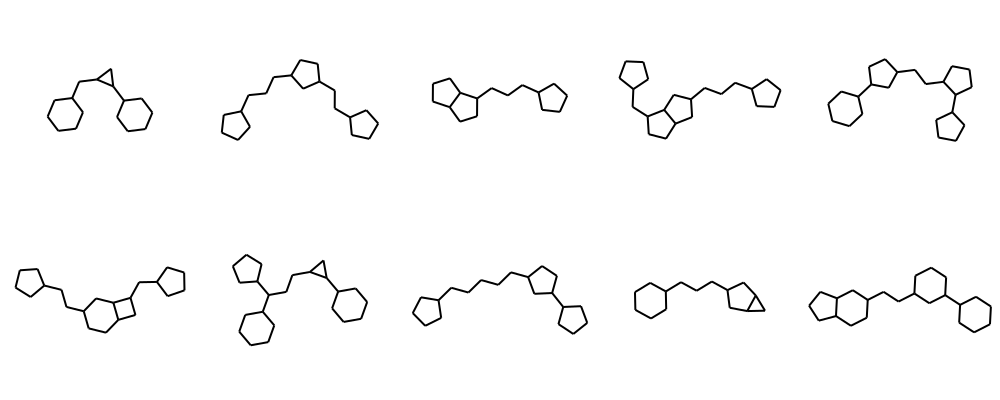

In [58]:
Draw.MolsToGridImage(smil_uniq_0['scaffold'], molsPerRow=5, maxMols=10)

,count,prob,scaffold
72,3,0.001763,
62,3,0.001763,
168,2,0.001175,
195,2,0.001175,
194,2,0.001175,
191,2,0.001175,
190,2,0.001175,
186,2,0.001175,
171,2,0.001175,
169,2,0.001175,

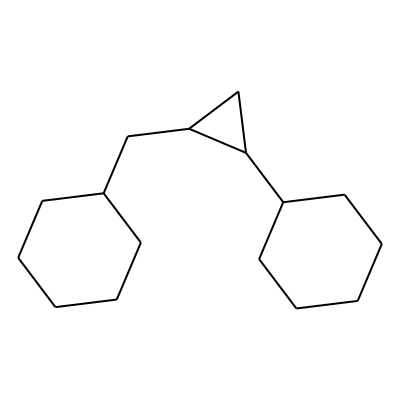
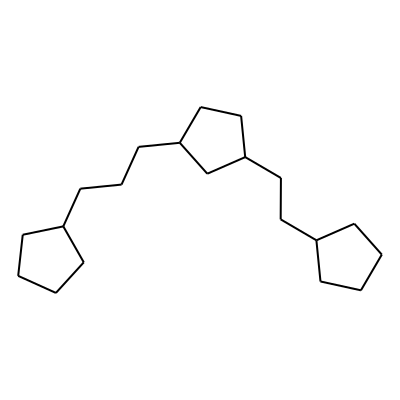
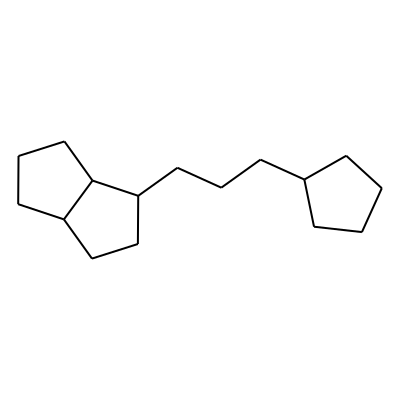
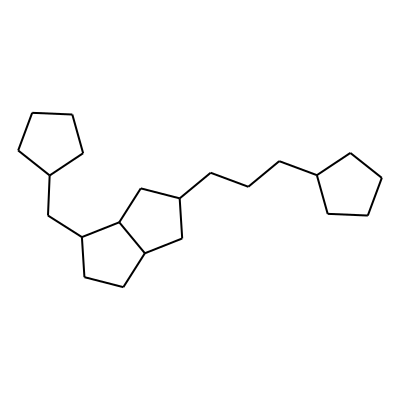
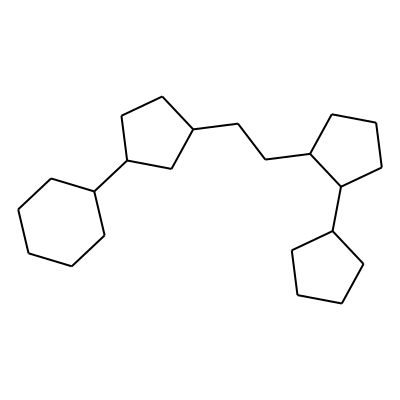
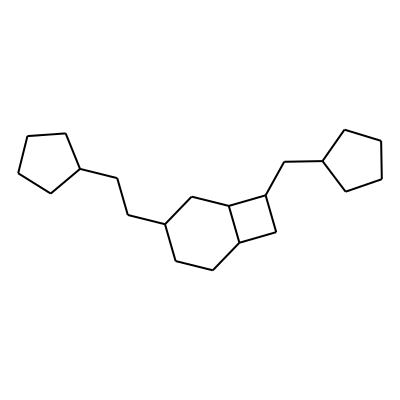
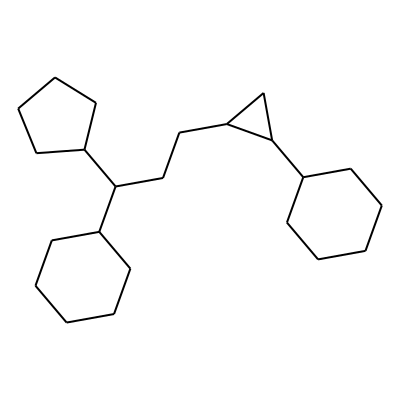
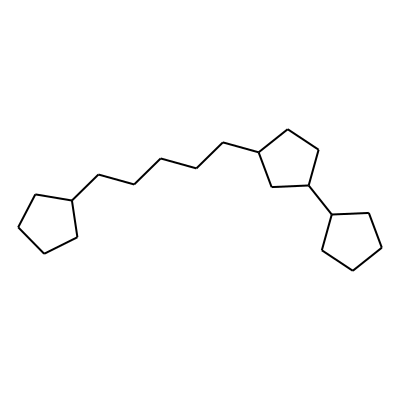
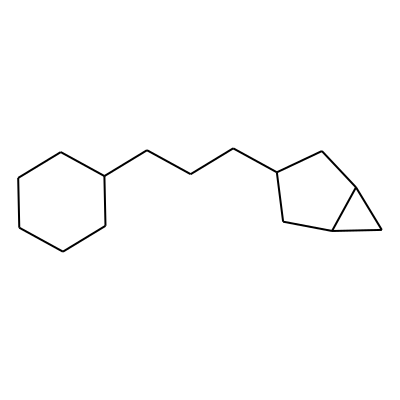
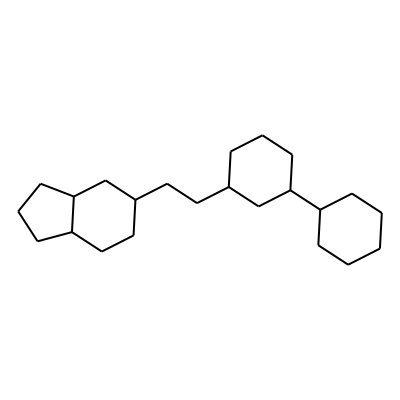

In [59]:
HTML(smil_uniq_0[['count','prob','scaffold']].head(10).to_html(formatters={'scaffold': mol_display}, escape=False))

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


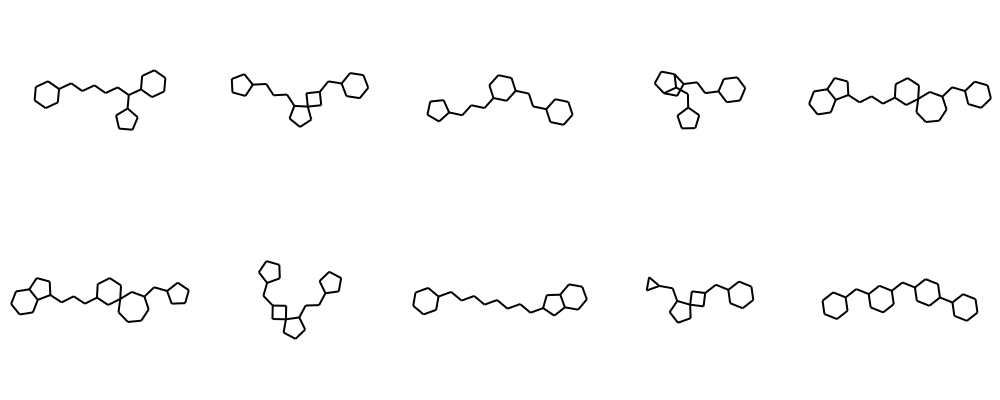

In [60]:
Draw.MolsToGridImage(smil_uniq_1['scaffold'], molsPerRow=5, maxMols=10)

,count,prob,scaffold
79,5,0.001423,
84,5,0.001423,
113,4,0.001138,
114,4,0.001138,
125,4,0.001138,
156,3,0.000854,
141,3,0.000854,
139,3,0.000854,
214,3,0.000854,
213,3,0.000854,

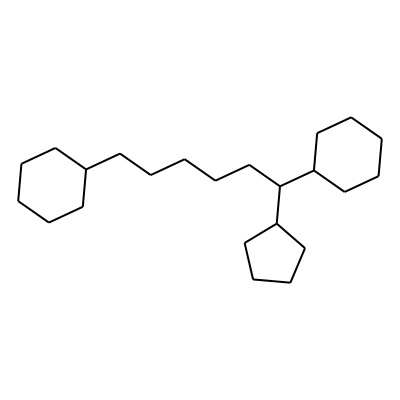
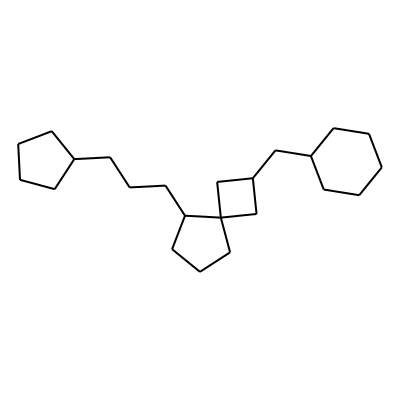
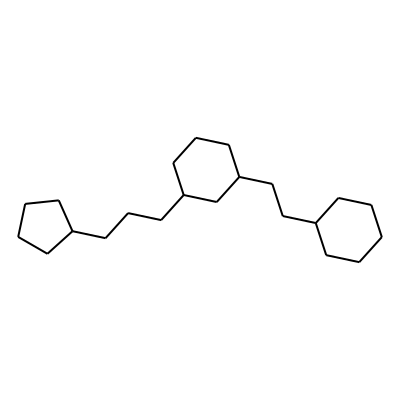
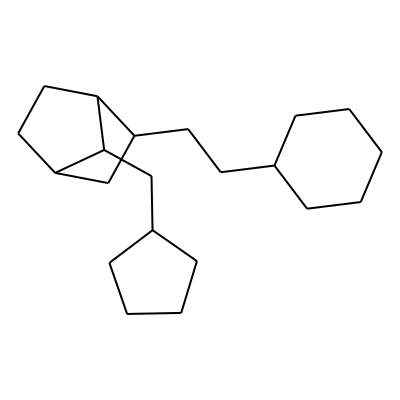
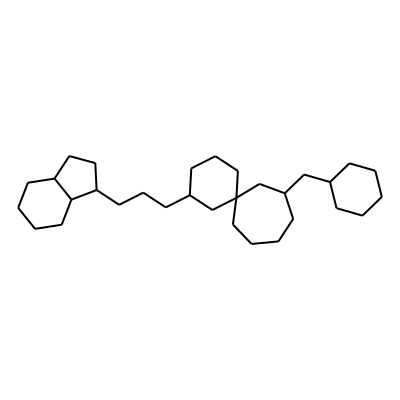
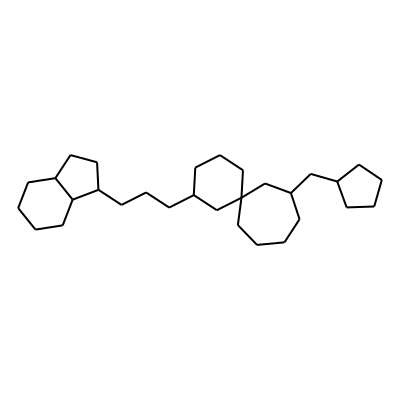
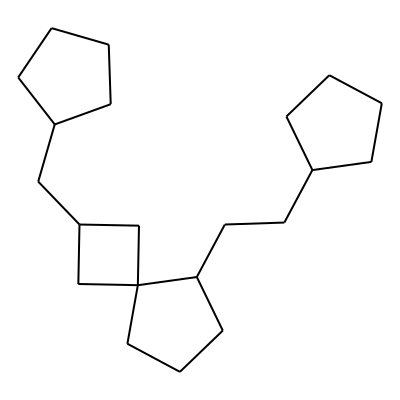
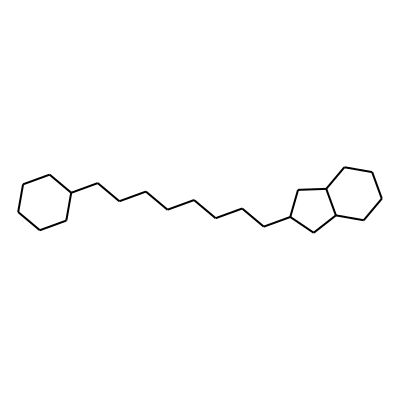
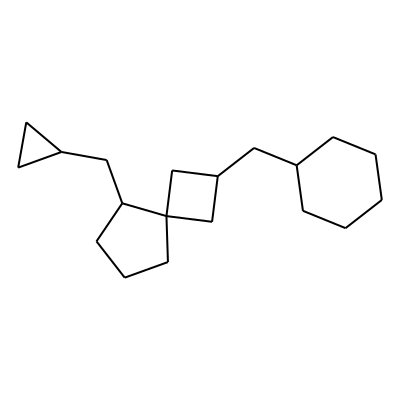
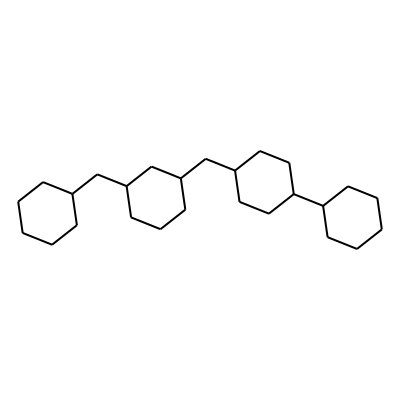

In [61]:
HTML(smil_uniq_1[['count','prob','scaffold']].head(10).to_html(formatters={'scaffold': mol_display}, escape=False))

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


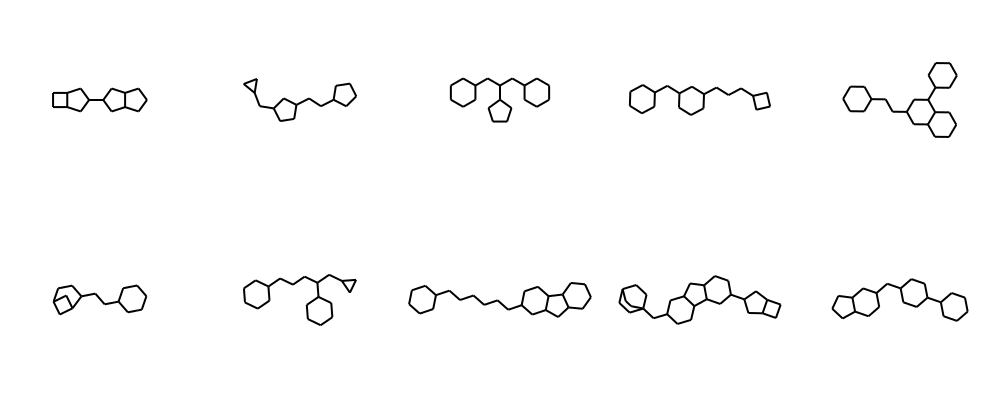

In [62]:
Draw.MolsToGridImage(smil_uniq_2['scaffold'], molsPerRow=5, maxMols=10)

,count,prob,scaffold
65,6,0.001388,
192,3,0.000694,
219,3,0.000694,
218,3,0.000694,
211,3,0.000694,
200,3,0.000694,
193,3,0.000694,
183,3,0.000694,
181,3,0.000694,
178,3,0.000694,

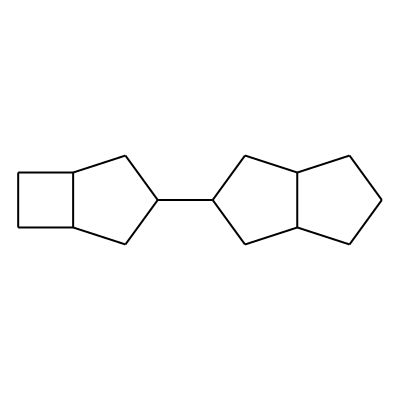
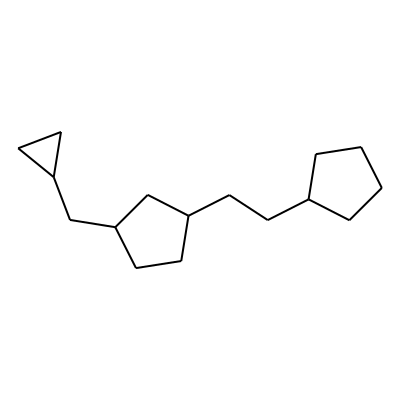
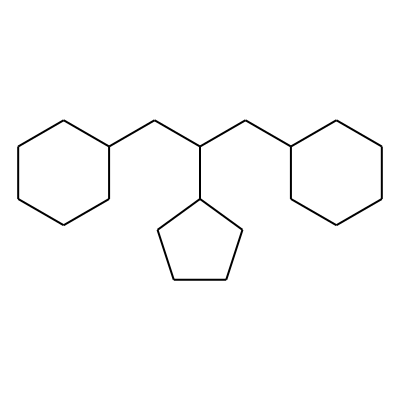
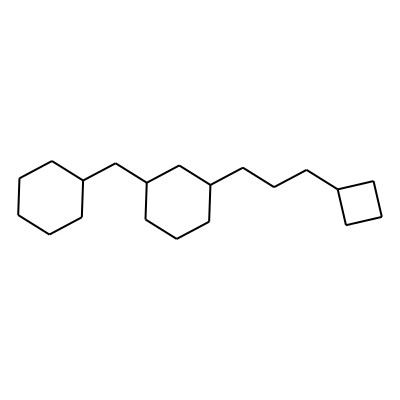
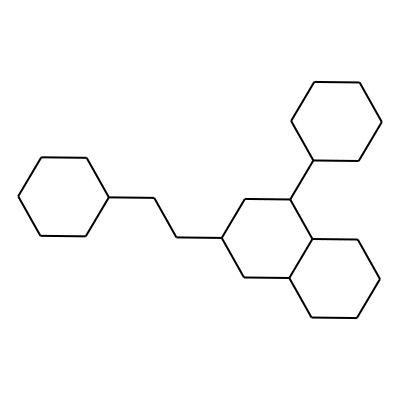
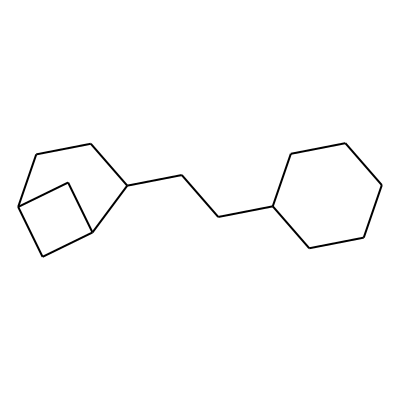
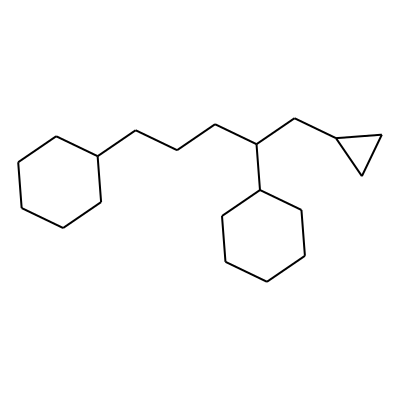
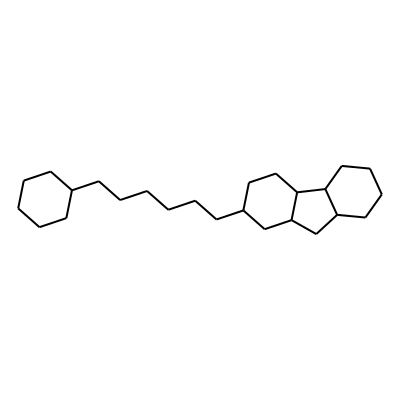
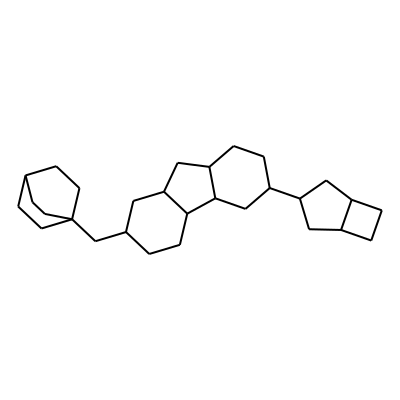
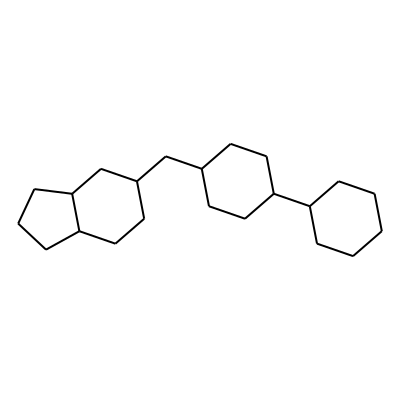

In [63]:
HTML(smil_uniq_2[['count','prob','scaffold']].head(10).to_html(formatters={'scaffold': mol_display}, escape=False))

/home/zumrovad/.conda/envs/az/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 20. Change the maxMols value to display more.
  warnings.warn(


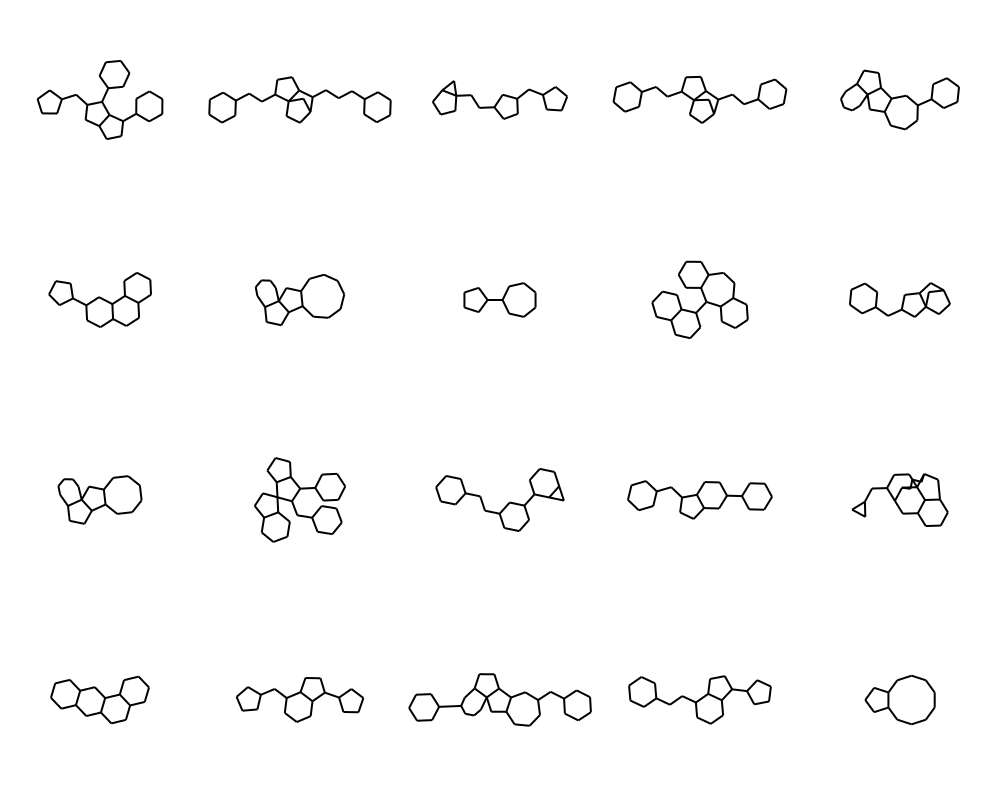

In [64]:
Draw.MolsToGridImage(smil_uniq_3['scaffold'], molsPerRow=5, maxMols=20)

,count,prob,scaffold
56,10,0.001568,
75,8,0.001254,
103,6,0.000941,
158,5,0.000784,
125,5,0.000784,
135,5,0.000784,
142,5,0.000784,
144,5,0.000784,
133,5,0.000784,
128,5,0.000784,

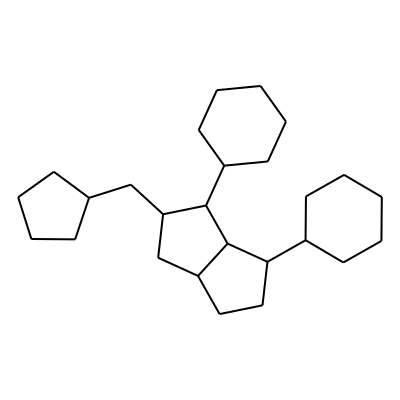
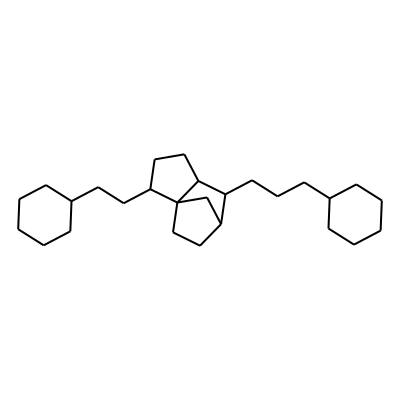
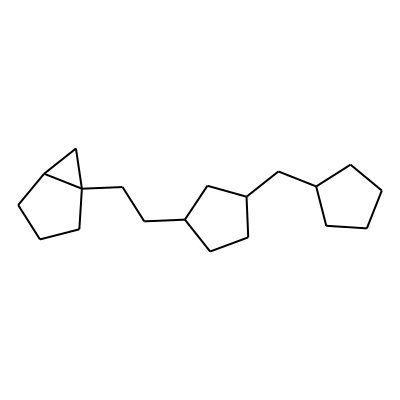
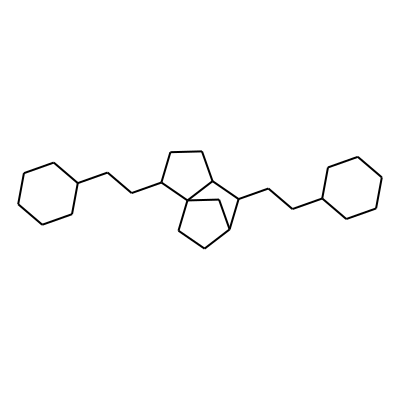
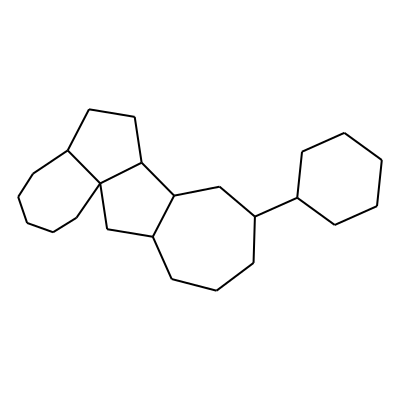
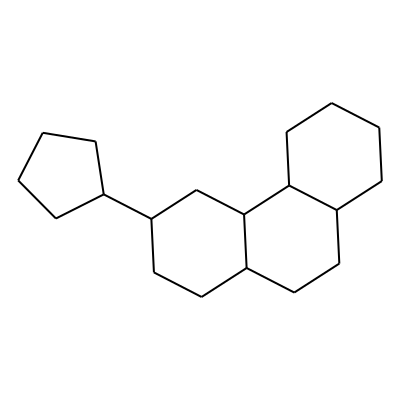
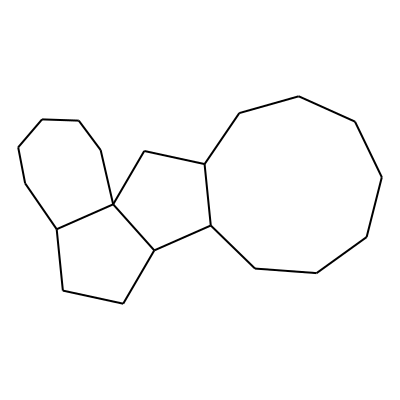
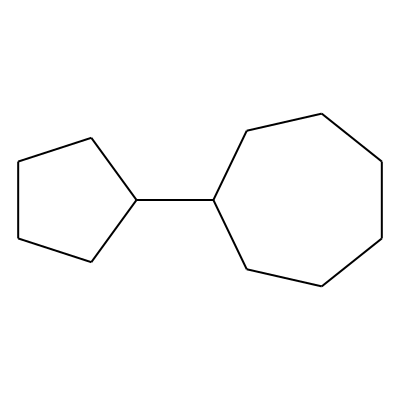
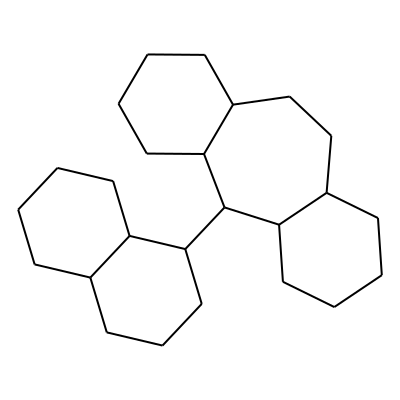
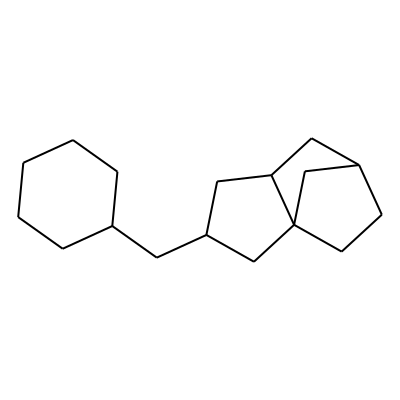

In [65]:
HTML(smil_uniq_3[['count','prob','scaffold']].head(10).to_html(formatters={'scaffold': mol_display}, escape=False))

# Ratio of probabilities

In [87]:
scaffolds_merge = smil0.merge(smil1, left_on='index', right_on='index')
scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [90]:
scaffolds_merge.head(7)

,index,scaf3_smiles_x,scaffold_x,prob_x,group_x,scaf3_smiles_y,scaffold_y,prob_y,group_y,prob_ratio
37,C1CCC(C2CCC(CCCCC3CCCC3)C2)CC1,5,<rdkit.Chem.rdchem.Mol object at 0x7f51c03aff40>,0.002938,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baff44c0>,0.000285,1,10.323149
48,C1CCC(CCCC2CCC3CCCC3C2)C1,4,<rdkit.Chem.rdchem.Mol object at 0x7f51c296e3a0>,0.002350,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafead00>,0.000285,1,8.258519
46,C1CCC(C2CCCC(CCC3CCCC3)C2)CC1,4,<rdkit.Chem.rdchem.Mol object at 0x7f51c296e2e0>,0.002350,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafea700>,0.000285,1,8.258519
29,C1CCC(CCCC2CCC(CC3CCCC3)C2)CC1,7,<rdkit.Chem.rdchem.Mol object at 0x7f51c03afc40>,0.004113,0,2,<rdkit.Chem.rdchem.Mol object at 0x7f51bafe3d60>,0.000569,1,7.226204
24,C1CCC(CCC2CCC(CC3CCCC3)C2)CC1,9,<rdkit.Chem.rdchem.Mol object at 0x7f51c03afa60>,0.005288,0,3,<rdkit.Chem.rdchem.Mol object at 0x7f51bafe0fa0>,0.000854,1,6.193890
76,C1CCC(CCC23CCCCC2C3)CC1,3,<rdkit.Chem.rdchem.Mol object at 0x7f51c296eee0>,0.001763,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafef820>,0.000285,1,6.193890
72,C1CCC(CCCCC2CC3CCC2C3)C1,3,<rdkit.Chem.rdchem.Mol object at 0x7f51c296ed60>,0.001763,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafc8ac0>,0.000285,1,6.193890


,scaffold_x,prob_ratio,prob_x,prob_y
37,,10.323149,0.002938,0.000285
48,,8.258519,0.002350,0.000285
46,,8.258519,0.002350,0.000285
29,,7.226204,0.004113,0.000569
24,,6.193890,0.005288,0.000854
76,,6.193890,0.001763,0.000285
72,,6.193890,0.001763,0.000285
71,,6.193890,0.001763,0.000285
65,,6.193890,0.001763,0.000285
87,,6.193890,0.001763,0.000285

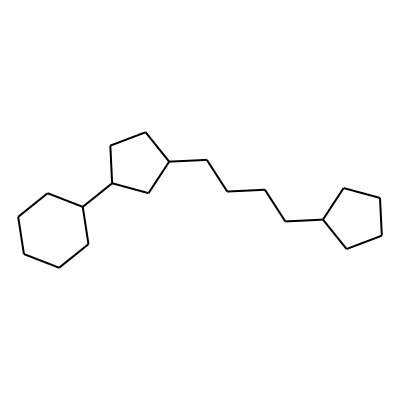
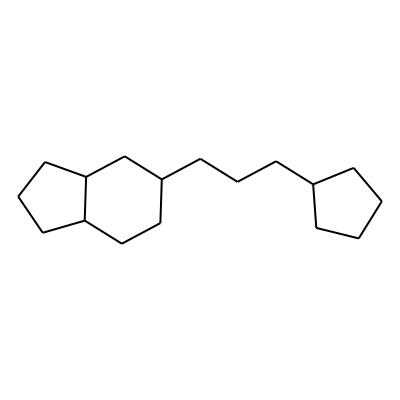
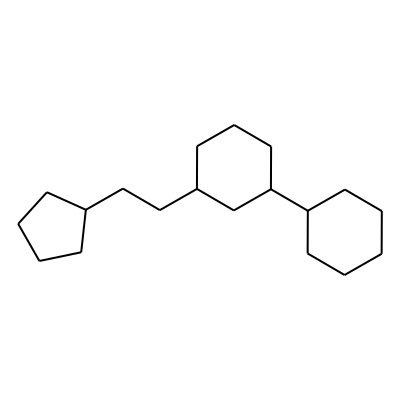
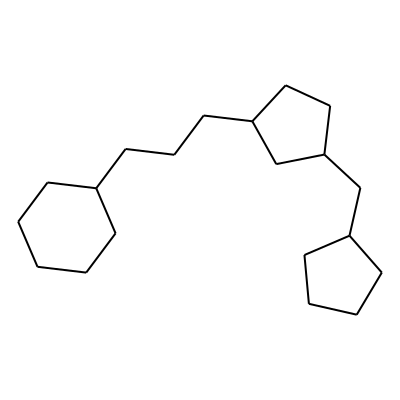
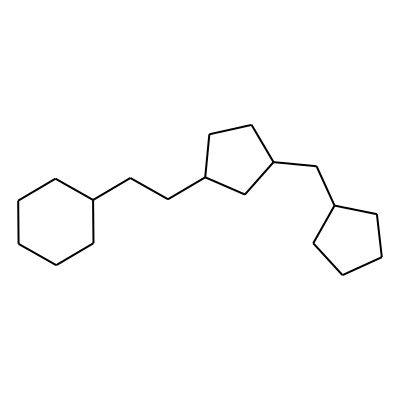
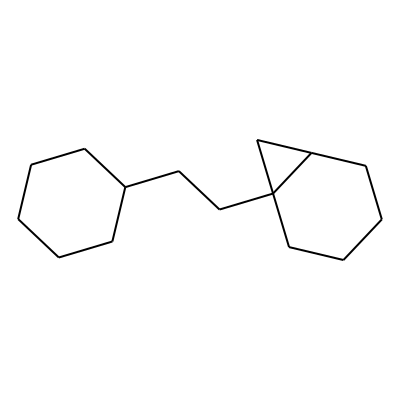
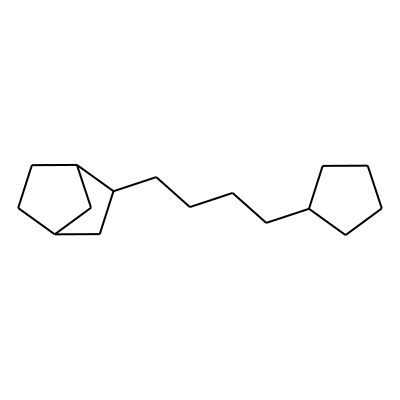
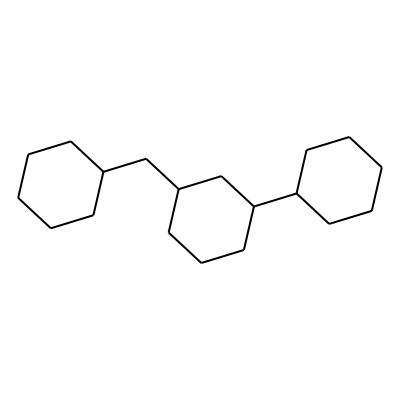
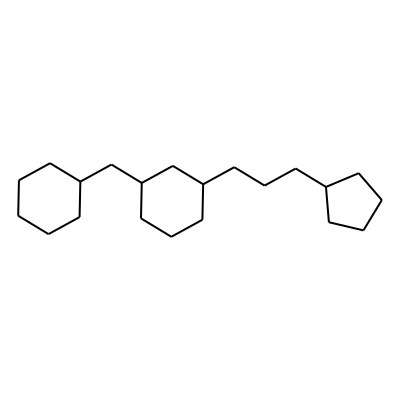
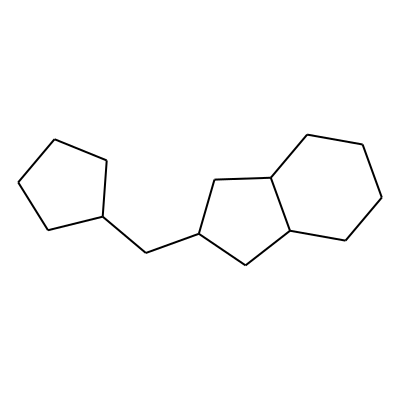

In [70]:
# More often in group 0
HTML(scaffolds_merge[['scaffold_x','prob_ratio','prob_x','prob_y']].head(10).to_html(
    formatters={'scaffold_x': mol_display}, escape=False))

,scaffold_x,prob_ratio,prob_x,prob_y
318,,0.344105,0.000588,0.001707
250,,0.344105,0.000588,0.001707
274,,0.344105,0.000588,0.001707
183,,0.344105,0.000588,0.001707
229,,0.294947,0.000588,0.001992
121,,0.294947,0.001175,0.003984
293,,0.294947,0.000588,0.001992
273,,0.294947,0.000588,0.001992
306,,0.258079,0.000588,0.002277
181,,0.187694,0.000588,0.003130

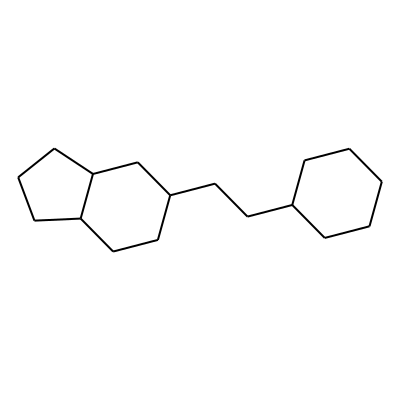
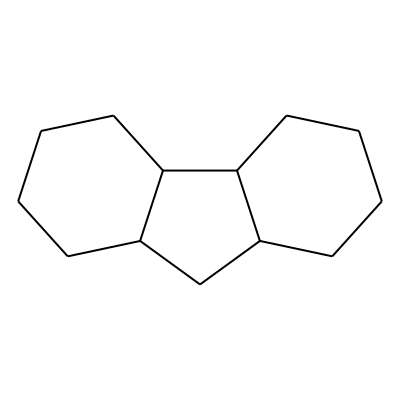
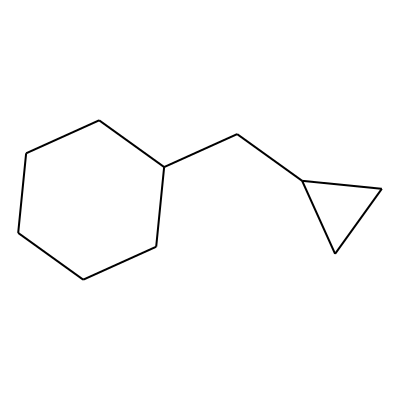
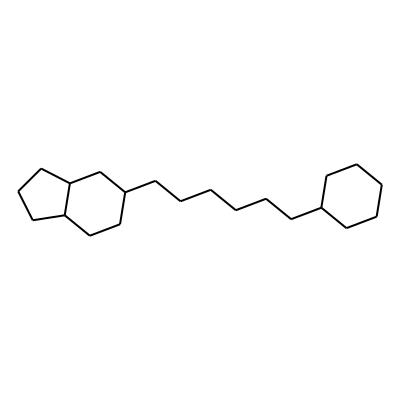
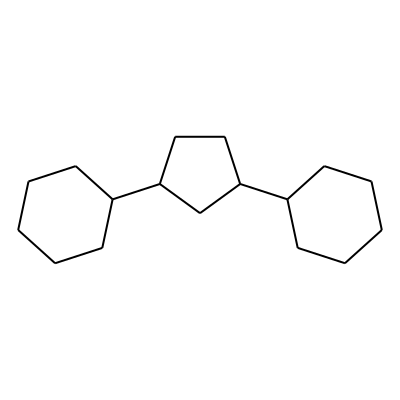
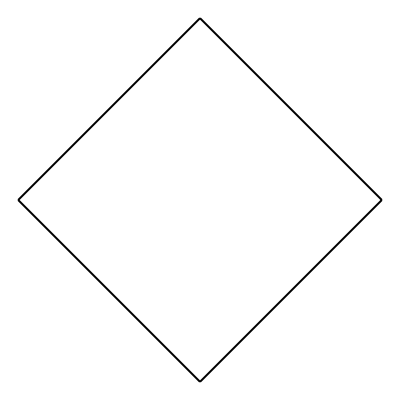
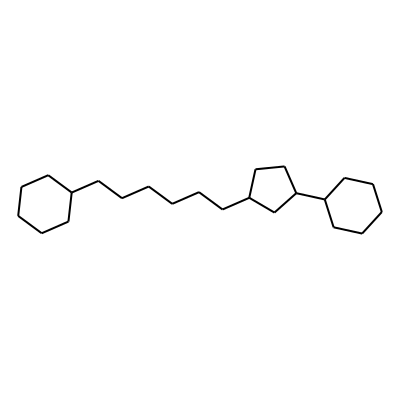
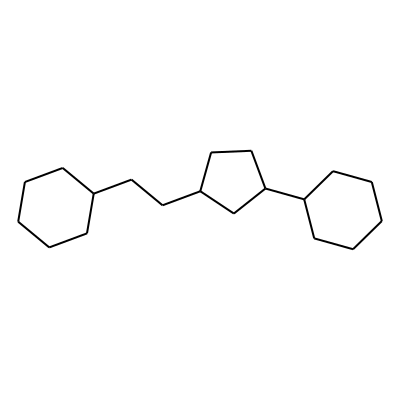
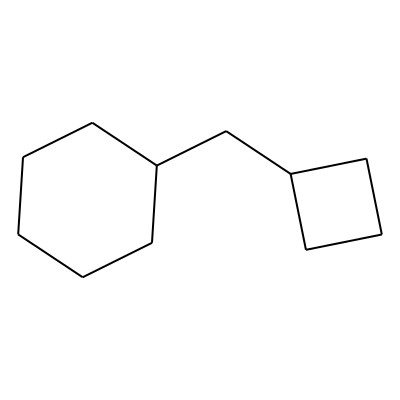
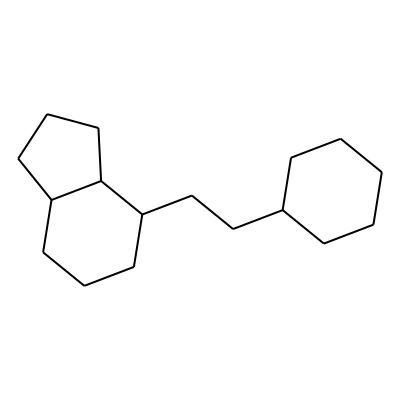

In [71]:
# More often in group 1
HTML(scaffolds_merge[['scaffold_x','prob_ratio','prob_x','prob_y']].tail(10).to_html(
    formatters={'scaffold_x': mol_display}, escape=False))

In [72]:
scaffolds_merge = smil0.merge(smil3, left_on='index', right_on='index')
scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [73]:
scaffolds_merge.head()

,index,scaf3_smiles_x,scaffold_x,prob_x,group_x,scaf3_smiles_y,scaffold_y,prob_y,group_y,prob_ratio
20,C(CCCCC1CCCC1)CCCC1CCCCC1,10,<rdkit.Chem.rdchem.Mol object at 0x7f51c03af8e0>,0.005875,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf01640>,0.000157,3,37.473561
26,C1CCC(CCCCC2CC2)CC1,8,<rdkit.Chem.rdchem.Mol object at 0x7f51c03afb20>,0.004700,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf6bdc0>,0.000157,3,29.978848
28,C1CCC(CCCC2CCC(CC3CCCC3)C2)CC1,7,<rdkit.Chem.rdchem.Mol object at 0x7f51c03afc40>,0.004113,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf14d60>,0.000157,3,26.231492
31,C(CCC1CCCC1)CCC1CCCC1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51c03afd60>,0.003525,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf732e0>,0.000157,3,22.484136
42,C1CCC(CCCC2CCC2)C1,5,<rdkit.Chem.rdchem.Mol object at 0x7f51c296e280>,0.002938,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf73be0>,0.000157,3,18.736780


In [74]:
len(scaffolds_merge), len(smil0), len(smil3)

(288, 783, 3164)

,scaffold_x,prob_ratio,prob_x,prob_y
20,,37.473561,0.005875,0.000157
26,,29.978848,0.004700,0.000157
28,,26.231492,0.004113,0.000157
31,,22.484136,0.003525,0.000157
42,,18.736780,0.002938,0.000157
39,,18.736780,0.002938,0.000157
36,,18.736780,0.002938,0.000157
24,,11.242068,0.005288,0.000470
75,,11.242068,0.001763,0.000157
80,,11.242068,0.001763,0.000157

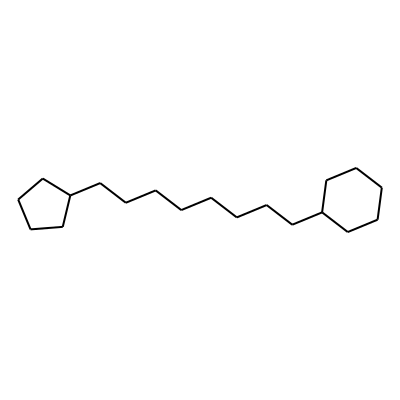
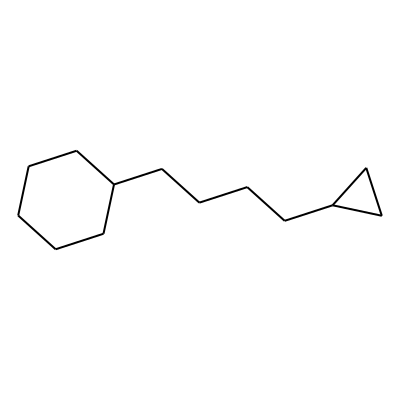
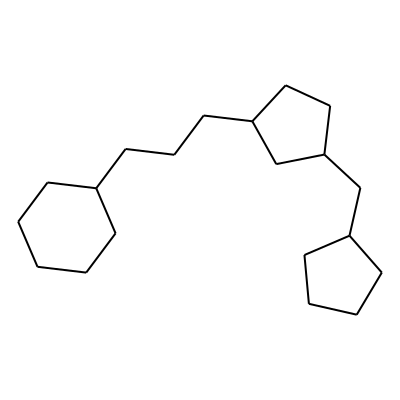
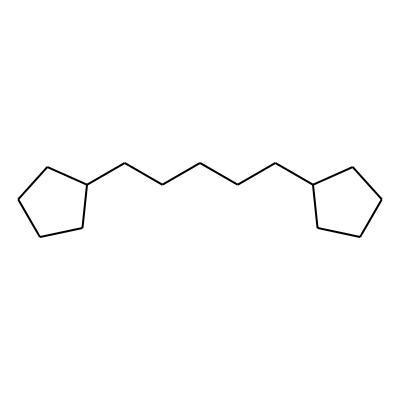
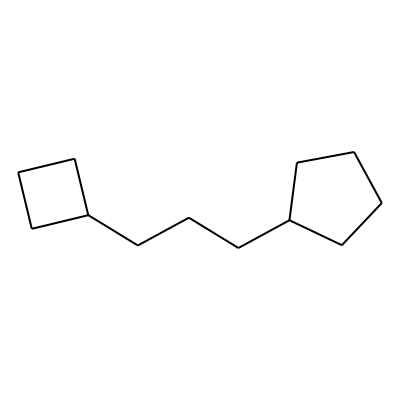
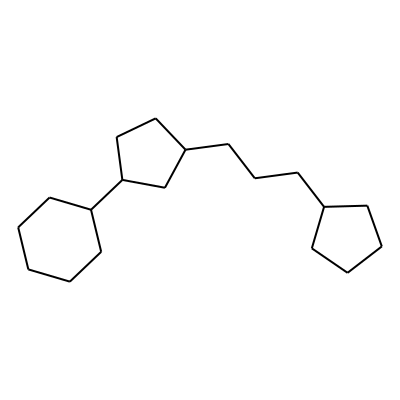
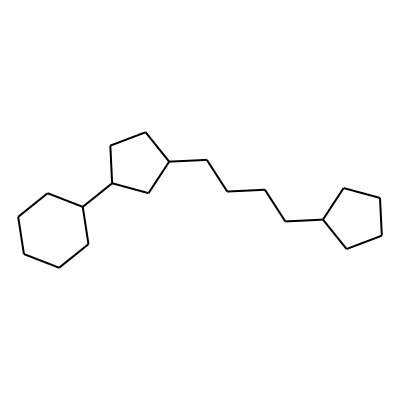
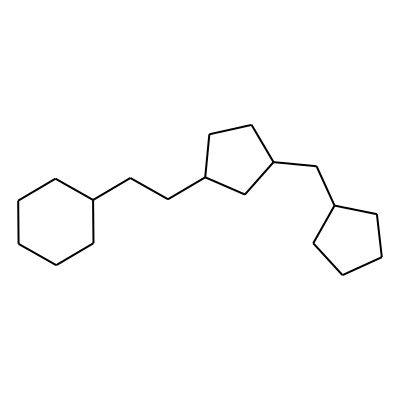
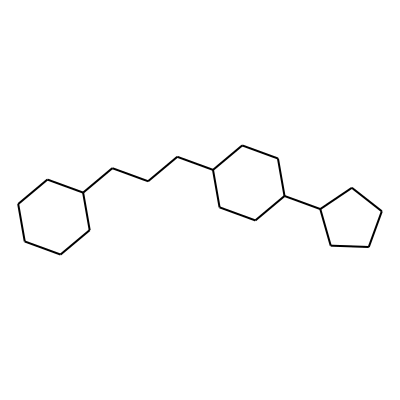
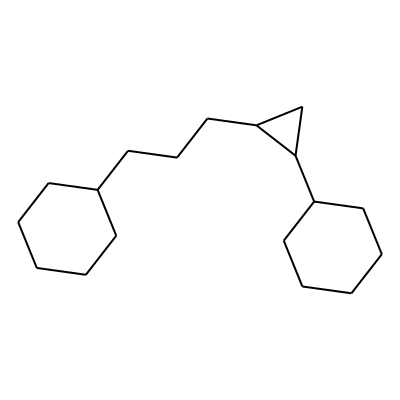

In [75]:
# More often in group 0
HTML(scaffolds_merge[['scaffold_x','prob_ratio','prob_x','prob_y']].head(10).to_html(
    formatters={'scaffold_x': mol_display}, escape=False))

,scaffold_y,prob_ratio,prob_x,prob_y
207,,0.340669,0.000588,0.001725
167,,0.340669,0.000588,0.001725
241,,0.288258,0.000588,0.002038
271,,0.267668,0.000588,0.002195
214,,0.249824,0.000588,0.002352
137,,0.241765,0.001175,0.004860
213,,0.234210,0.000588,0.002509
247,,0.220433,0.000588,0.002665
263,,0.149894,0.000588,0.003920
149,,0.144129,0.000588,0.004077

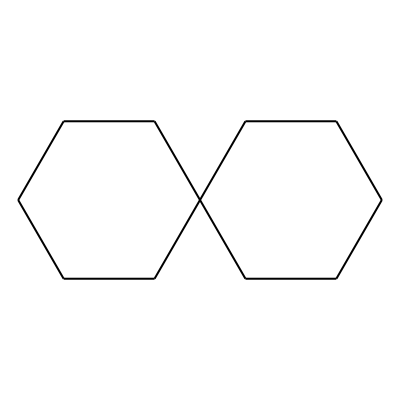
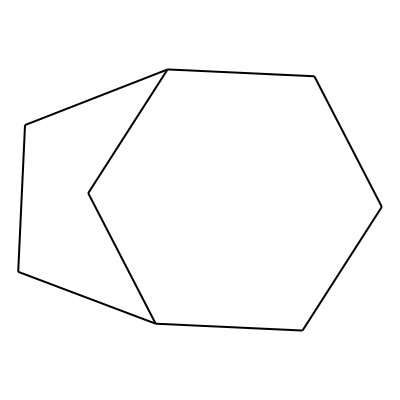
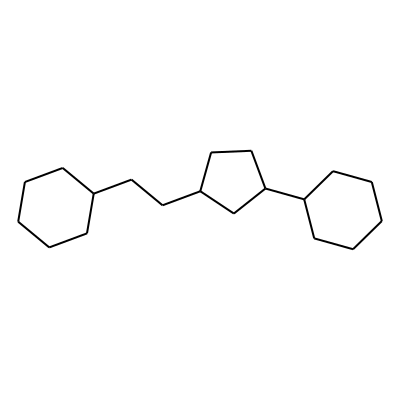
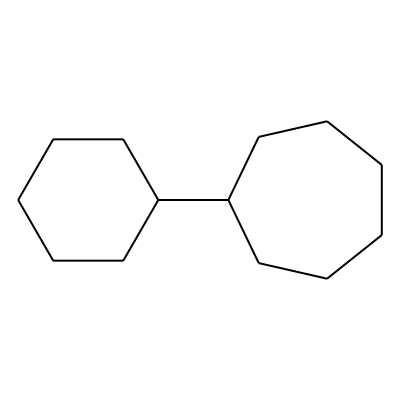
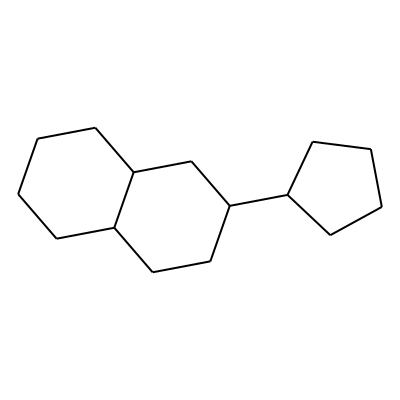
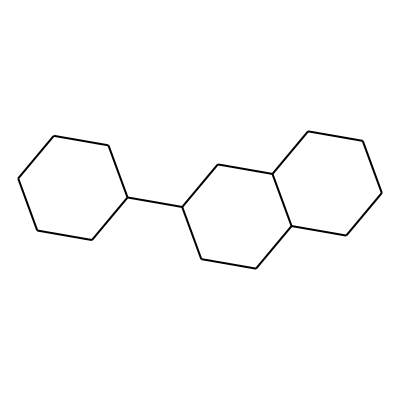
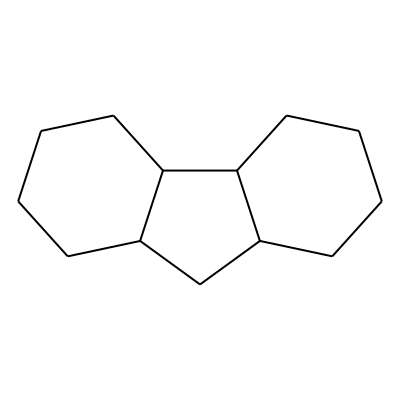
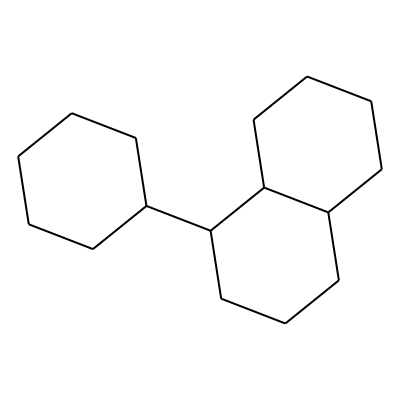
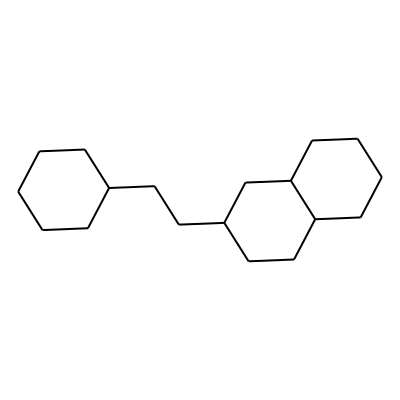
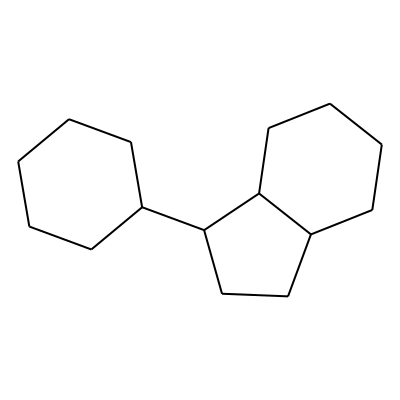

In [76]:
# More often in group 3
HTML(scaffolds_merge[['scaffold_y','prob_ratio','prob_x','prob_y']].tail(10).to_html(
    formatters={'scaffold_y': mol_display}, escape=False))

In [77]:
scaffolds_merge = smil1.merge(smil2, left_on='index', right_on='index')
scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [78]:
scaffolds_merge.head()

,index,scaf3_smiles_x,scaffold_x,prob_x,group_x,scaf3_smiles_y,scaffold_y,prob_y,group_y,prob_ratio
37,C1CCC(CC2CC3(CCCC3CCC3CCCC3)C2)CC1,8,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdd460>,0.002277,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf915e0>,0.000231,2,9.844052
69,C1CCC(CCCC2CCCC3CCCCC32)C1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51bafde100>,0.001707,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafa6e80>,0.000231,2,7.383039
70,C1CCC(CCC2CCCC3CCCC32)C1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51bafde160>,0.001707,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf91a00>,0.000231,2,7.383039
53,C1CCC(CCC2CC(CCC3CCCC3)C2)C1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51bafdda60>,0.001707,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafb3700>,0.000231,2,7.383039
61,C(CCCC1CCC2CCCC2C1)CCC1CCCCC1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51bafddd60>,0.001707,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51bafa9040>,0.000231,2,7.383039


,scaffold_x,prob_ratio,prob_x,prob_y
37,,9.844052,0.002277,0.000231
69,,7.383039,0.001707,0.000231
70,,7.383039,0.001707,0.000231
53,,7.383039,0.001707,0.000231
61,,7.383039,0.001707,0.000231
20,,6.152533,0.004269,0.000694
75,,6.152533,0.001423,0.000231
77,,6.152533,0.001423,0.000231
83,,6.152533,0.001423,0.000231
30,,5.537279,0.002561,0.000463

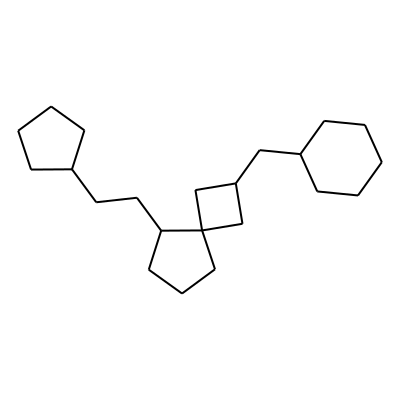
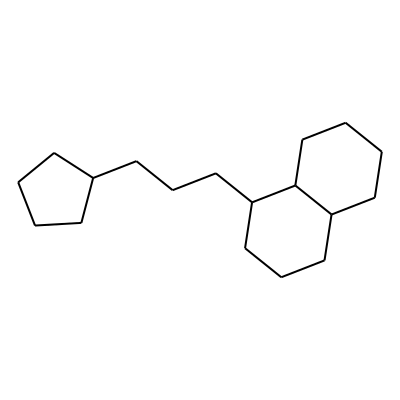
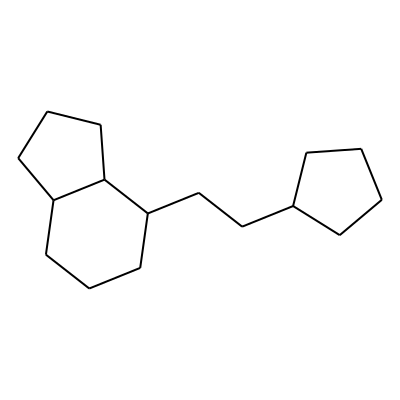
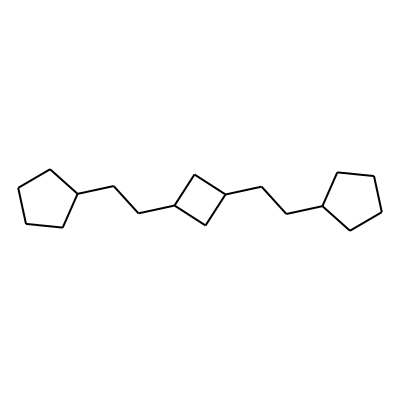
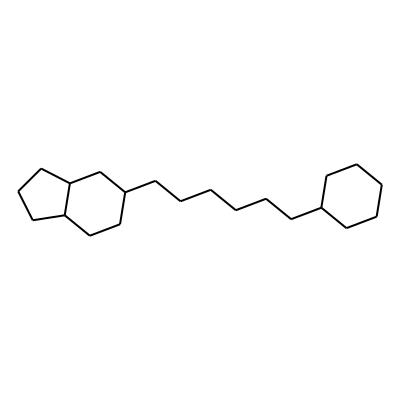
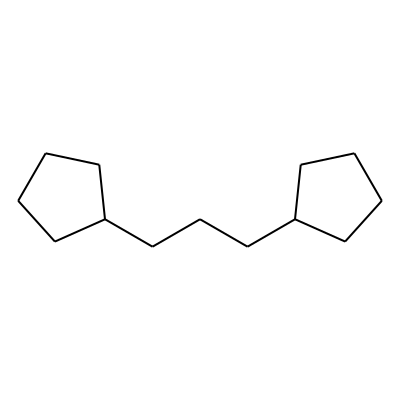
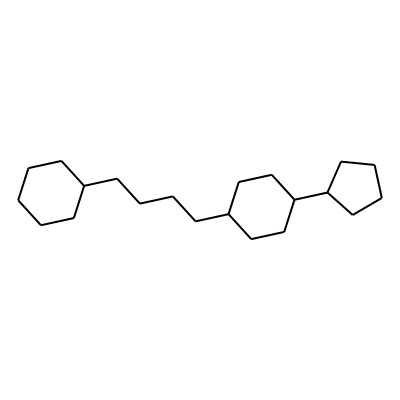
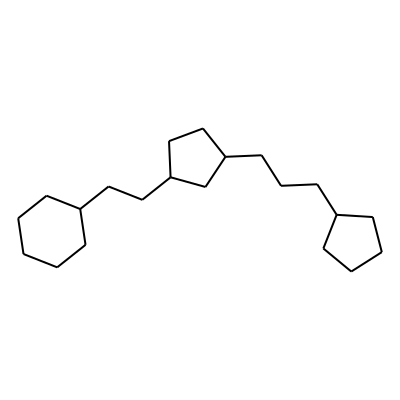
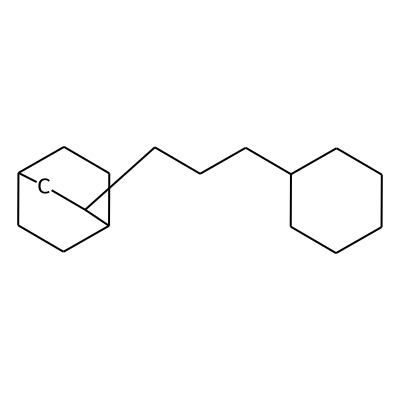
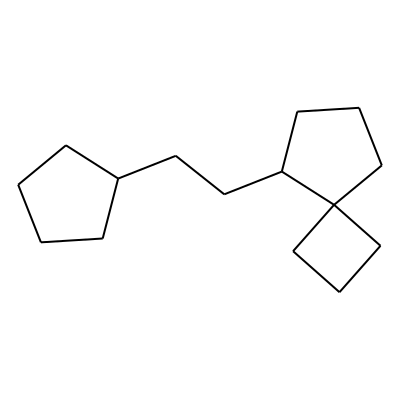

In [79]:
# More often in group 1
HTML(scaffolds_merge[['scaffold_x','prob_ratio','prob_x','prob_y']].head(10).to_html(
    formatters={'scaffold_x': mol_display}, escape=False))

,scaffold_y,prob_ratio,prob_x,prob_y
306,,0.307627,0.000285,0.000925
393,,0.246101,0.000285,0.001156
377,,0.246101,0.000285,0.001156
298,,0.246101,0.000285,0.001156
303,,0.246101,0.000285,0.001156
114,,0.223728,0.001138,0.005088
394,,0.205084,0.000285,0.001388
415,,0.175787,0.000285,0.001619
442,,0.175787,0.000285,0.001619
294,,0.111864,0.000285,0.002544

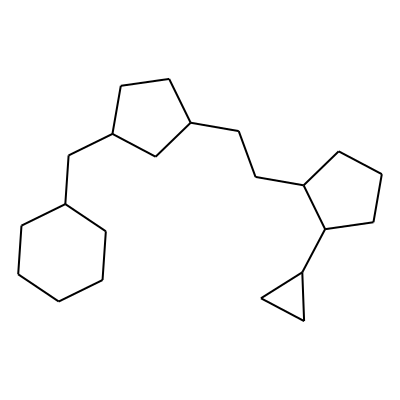
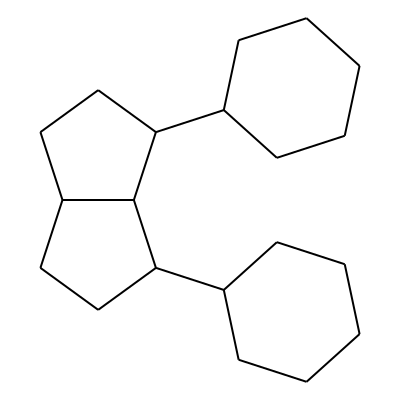
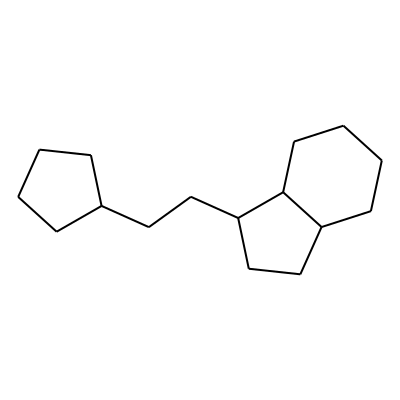
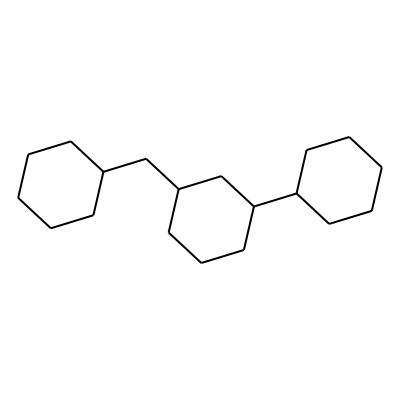
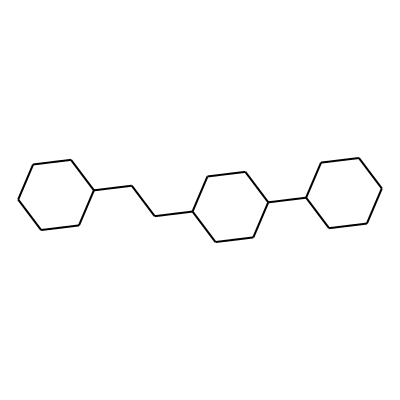
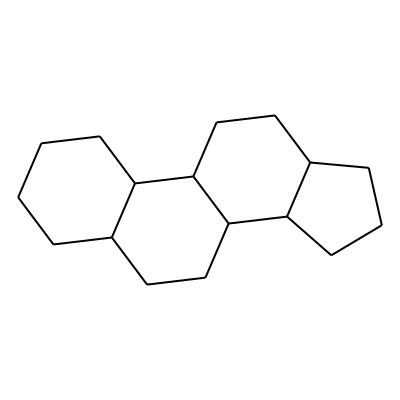
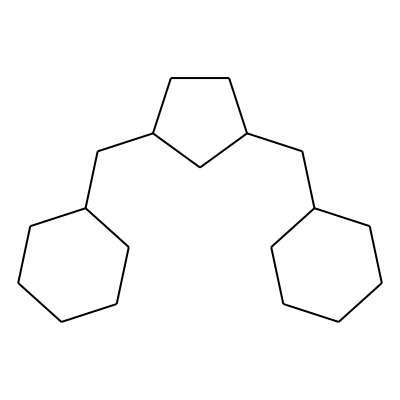
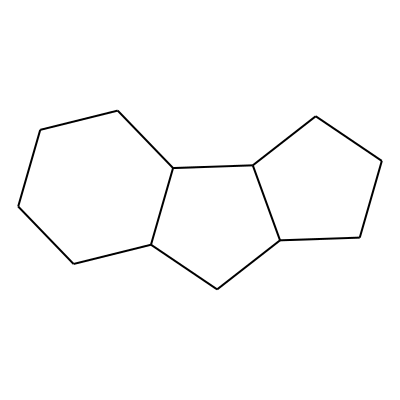
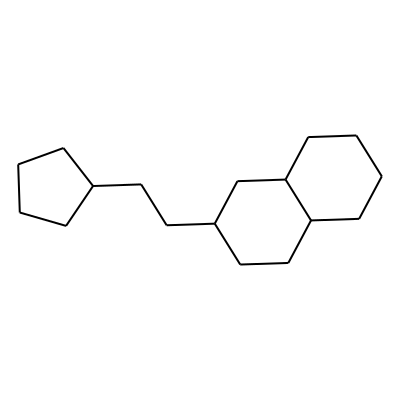
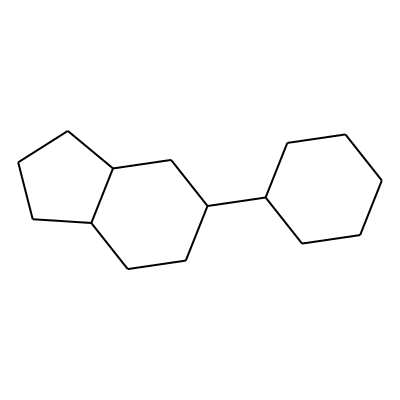

In [80]:
# More often in group 2
HTML(scaffolds_merge[['scaffold_y','prob_ratio','prob_x','prob_y']].tail(10).to_html(
    formatters={'scaffold_y': mol_display}, escape=False))

In [91]:
scaffolds_merge = smil2.merge(smil3, left_on='index', right_on='index')
scaffolds_merge["prob_ratio"] = scaffolds_merge['prob_x'] / scaffolds_merge['prob_y'] 
scaffolds_merge.sort_values(by=['prob_ratio'], ascending=False, inplace=True)

In [92]:
scaffolds_merge.tail()

,index,scaf3_smiles_x,scaffold_x,prob_x,group_x,scaf3_smiles_y,scaffold_y,prob_y,group_y,prob_ratio
474,C1CCC2C(C1)CCC1C2CCC2C3CCCCC3CCC21,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf9bf40>,0.000231,2,8,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4cfa0>,0.001254,3,0.184378
304,C1CCC2C(C1)CCC1CCCC12,2,<rdkit.Chem.rdchem.Mol object at 0x7f51baf8a6a0>,0.000463,2,16,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4aee0>,0.002509,3,0.184378
320,C1CCC(CCC2CCCC(CCC3CCCCC3)C2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7f51baf8b820>,0.000231,2,8,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4d160>,0.001254,3,0.184378
67,C1CCC(CCC2CCC3CC4CCC23C4)CC1,6,<rdkit.Chem.rdchem.Mol object at 0x7f51baf82520>,0.001388,2,49,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a6a0>,0.007683,3,0.180615
172,C1CC2CC3CCC2(C1)C3,3,<rdkit.Chem.rdchem.Mol object at 0x7f51baf855e0>,0.000694,2,26,<rdkit.Chem.rdchem.Mol object at 0x7f51baf4a8e0>,0.004077,3,0.170195


,scaffold_x,prob_ratio,prob_x,prob_y
64,,8.850139,0.001388,0.000157
83,,7.375116,0.001156,0.000157
94,,7.375116,0.001156,0.000157
78,,7.375116,0.001156,0.000157
84,,7.375116,0.001156,0.000157
90,,7.375116,0.001156,0.000157
104,,5.900093,0.000925,0.000157
118,,5.900093,0.000925,0.000157
116,,5.900093,0.000925,0.000157
121,,5.900093,0.000925,0.000157

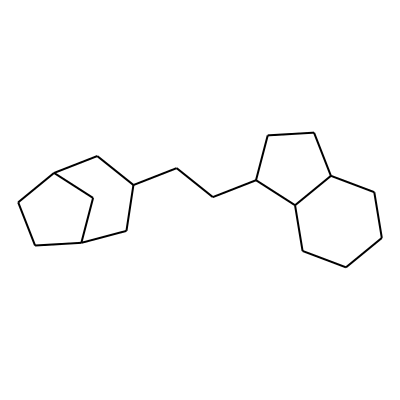
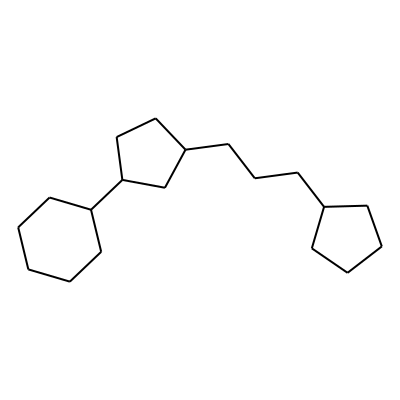
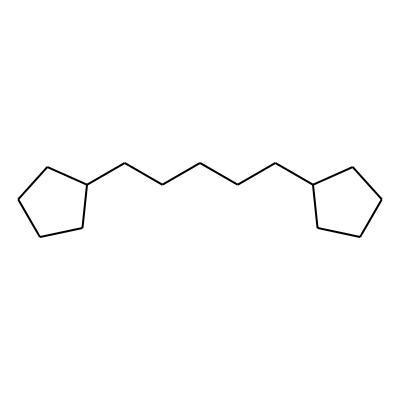
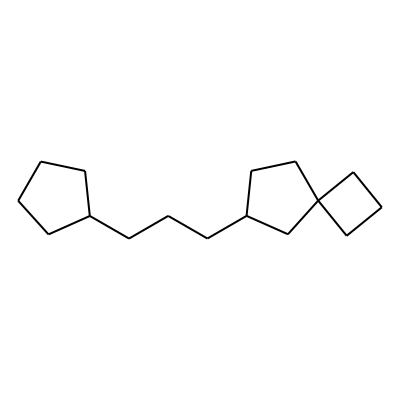
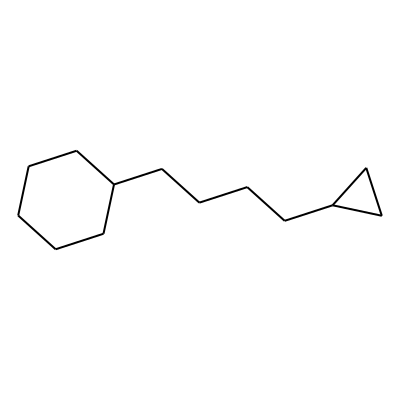
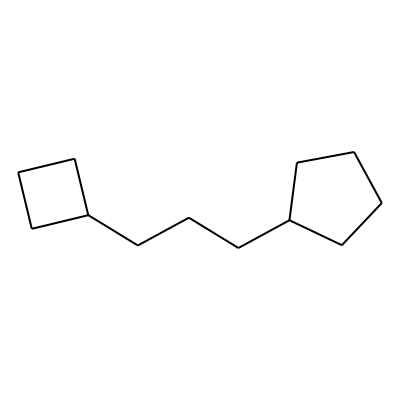
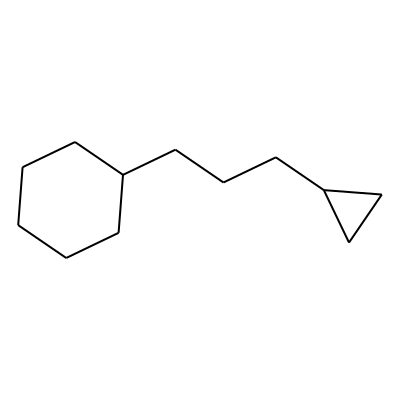
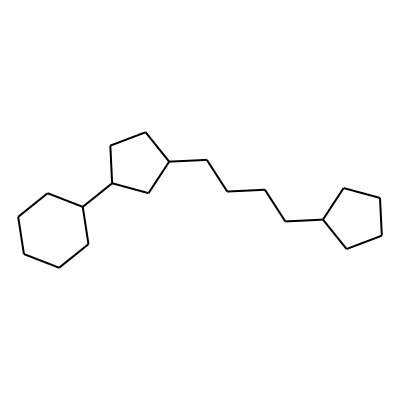
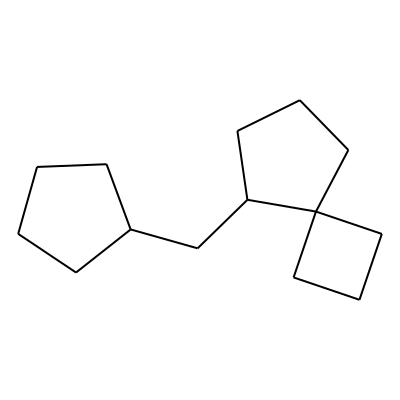
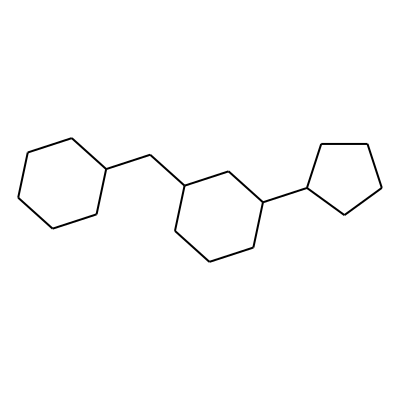

In [83]:
# More often in group 2
HTML(scaffolds_merge[['scaffold_x','prob_ratio','prob_x','prob_y']].head(10).to_html(
    formatters={'scaffold_x': mol_display}, escape=False))

,scaffold_y,prob_ratio,prob_x,prob_y
394,,0.245837,0.000231,0.000941
361,,0.245837,0.000231,0.000941
377,,0.245837,0.000231,0.000941
89,,0.237907,0.001156,0.004860
332,,0.210718,0.000231,0.001098
474,,0.184378,0.000231,0.001254
304,,0.184378,0.000463,0.002509
320,,0.184378,0.000231,0.001254
67,,0.180615,0.001388,0.007683
172,,0.170195,0.000694,0.004077

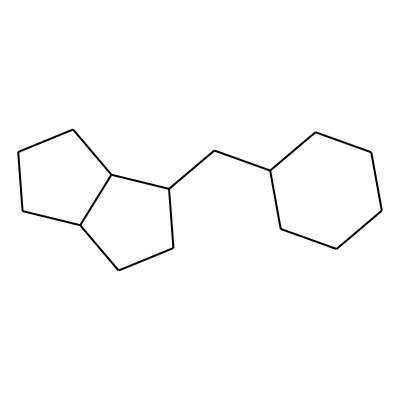
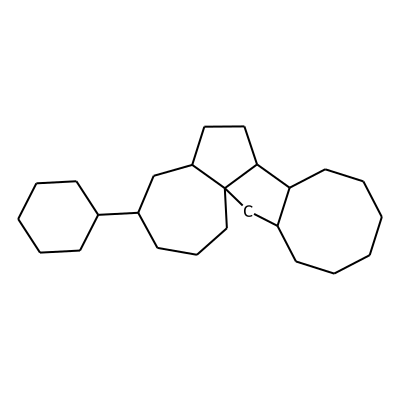
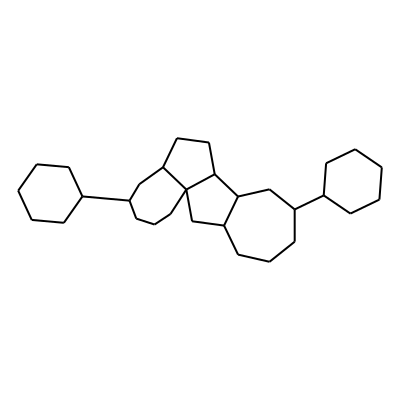
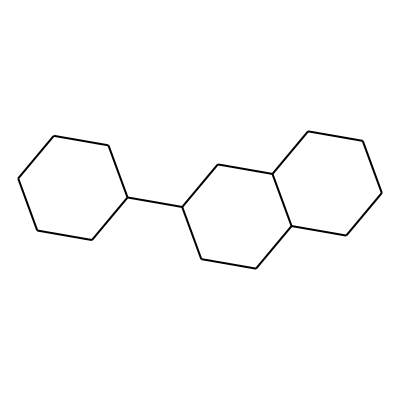
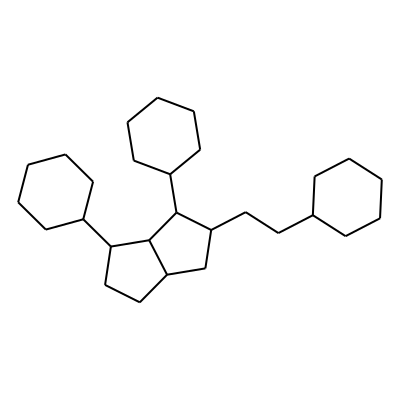
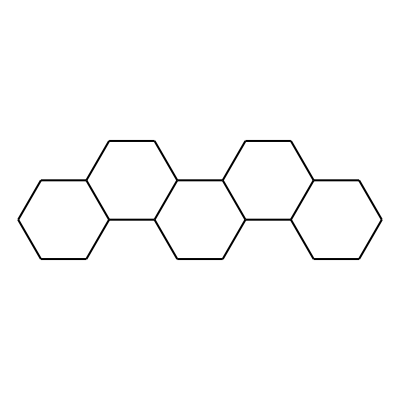
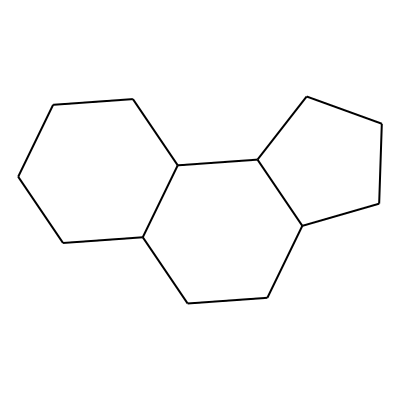
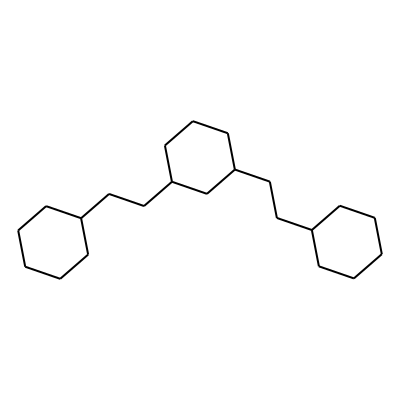
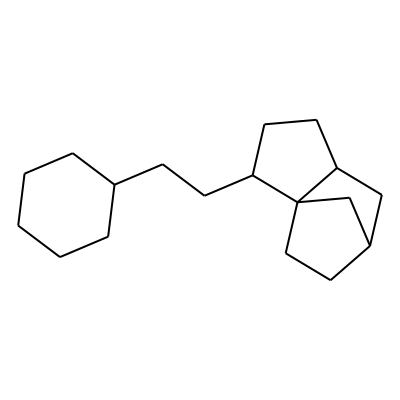
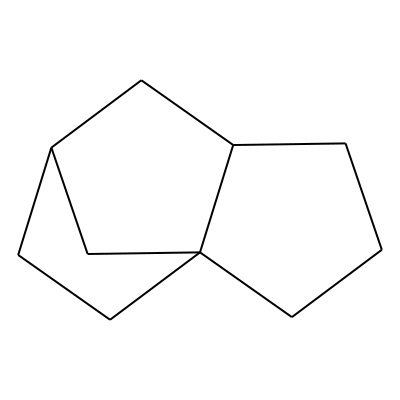

In [84]:
# More often in group 3
HTML(scaffolds_merge[['scaffold_y','prob_ratio','prob_x','prob_y']].tail(10).to_html(
    formatters={'scaffold_y': mol_display}, escape=False))

In [95]:
scaffolds_merge[scaffolds_merge.index == 94]['index']

94    C(CCC1CCCC1)CCC1CCCC1
Name: index, dtype: object

In [97]:
m = Chem.MolFromSmiles('C(CCC1CCCC1)CCC1CCCC1')

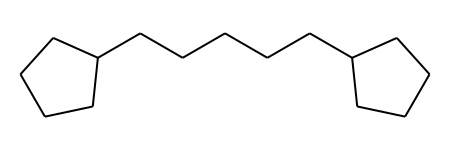

In [98]:
m

In [99]:
Draw.MolToFile(m,'sc more 2 - 7,4.png') 